In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
subjects = ["02", "03", '04', "05", "06"]

subj = "04"  # change subject ID here

df = pd.read_csv(f"../data/processed/sub-{subj}/tables/merged_annotated_with_audio.csv")

C:\Users\skite\AppData\Local\Temp\ipykernel_34476\4050067216.py:5: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../data/processed/sub-{subj}/tables/merged_annotated_with_audio.csv")


In [16]:
df.columns

Index(['ecg', 'respiration', 'physio_triggers', 'condition_triggers',
       'sequence', 'battery', 'flags', 'EEG-ch1', 'EEG-ch2', 'EEG-ch3',
       'EEG-ch4', 'EEG-ch5', 'EEG-ch6', 'EEG-ch7', 'EEG-ch8', 'EEG-ch9',
       'EEG-ch10', 'EEG-ch11', 'EEG-ch12', 'EEG-ch13', 'EEG-ch14', 'EEG-ch15',
       'EEG-ch16', 'EEG-ch17', 'EEG-ch18', 'EEG-ch19', 'EEG-ch20', 'EEG-ch21',
       'EEG-ch22', 'EEG-ch23', 'EEG-ch24', 'EEG-ch25', 'EEG-ch26', 'EEG-ch27',
       'EEG-ch28', 'EEG-ch29', 'EEG-ch30', 'EEG-ch31', 'EEG-ch32',
       'eeg_triggers', 'condition_names', 'time_s', 'env_broad',
       'env_swell_0p3', 'env_swell_0p1', 'env_splash_1_5'],
      dtype='object')

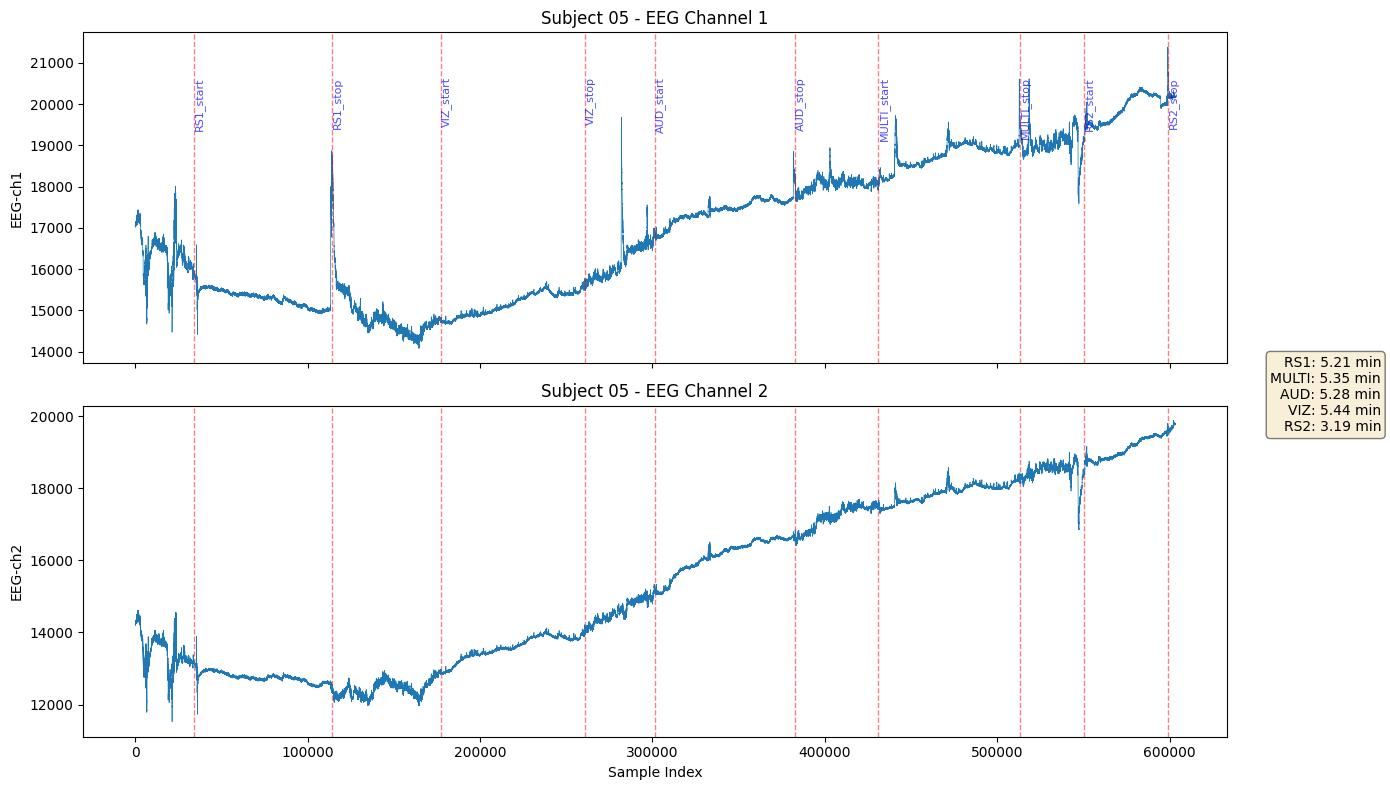

In [11]:
# plot EEG1 and EEG 2 with condition durations
sampling_rate = 256

# Calculate durations for each condition
conditions_to_check = ['RS1', 'MULTI', 'AUD', 'VIZ', 'RS2']
durations_text = []
condition_markers = {}

for cond in conditions_to_check:
    start_label = f'{cond}_start'
    stop_label = f'{cond}_stop'
    
    start_idx = df[df['condition_names'] == start_label].index
    stop_idx = df[df['condition_names'] == stop_label].index
    
    if len(start_idx) > 0 and len(stop_idx) > 0:
        duration_samples = stop_idx[0] - start_idx[0]
        duration_minutes = duration_samples / sampling_rate / 60
        durations_text.append(f"{cond}: {duration_minutes:.2f} min")
        
        # Store the indices and labels for plotting
        condition_markers[start_idx[0]] = start_label
        condition_markers[stop_idx[0]] = stop_label

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df['EEG-ch1'], linewidth=0.5)
axes[0].set_ylabel('EEG-ch1')
axes[0].set_title(f'Subject {subj} - EEG Channel 1')

# Add vertical lines and labels only at condition markers
for idx, label in condition_markers.items():
    axes[0].axvline(x=idx, color='r', linestyle='--', alpha=0.5, linewidth=1)
    axes[1].axvline(x=idx, color='r', linestyle='--', alpha=0.5, linewidth=1)
    
    y_pos = axes[0].get_ylim()[1] * 0.95
    axes[0].text(idx, y_pos, label, rotation=90, verticalalignment='top', 
                fontsize=8, alpha=0.7, color='blue')

axes[1].plot(df['EEG-ch2'], linewidth=0.5)
axes[1].set_ylabel('EEG-ch2')
axes[1].set_title(f'Subject {subj} - EEG Channel 2')
axes[1].set_xlabel('Sample Index')

# Add durations text box
durations_str = '\n'.join(durations_text)
fig.text(0.99, 0.5, durations_str, transform=fig.transFigure, 
         fontsize=10, verticalalignment='center', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for the text box
plt.show()


## Preprocessing

In [ ]:
from scipy import signal

def filter_eeg(df, sampling_rate=256, lowcut=1.0, highcut=50):
    """
    Simple EEG filtering without ICA artifact removal.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with EEG channels
    sampling_rate : int
        Sampling rate in Hz (default: 256)
    lowcut : float
        Low cutoff frequency for bandpass filter (default: 1.0 Hz)
    highcut : float
        High cutoff frequency for bandpass filter (default: 50 Hz)
    
    Returns
    -------
    df_filtered : pd.DataFrame
        Dataframe with bandpass filtered EEG channels
    """
    
    df_filtered = df.copy()
    
    # Get EEG channel names
    eeg_channels = [col for col in df.columns if col.startswith('EEG-ch')]
    print(f"Filtering {len(eeg_channels)} EEG channels")
    print(f"Bandpass filter: {lowcut}-{highcut} Hz")
    
    # Extract EEG data
    eeg_data = df[eeg_channels].values
    
    # Handle NaN values
    nan_mask = np.isnan(eeg_data)
    total_nans = nan_mask.sum()
    
    if total_nans > 0:
        print(f"  Found {total_nans} NaN values, interpolating...")
        eeg_data_clean = eeg_data.copy()
        for i in range(eeg_data.shape[1]):
            channel_data = eeg_data[:, i]
            nan_indices = np.where(np.isnan(channel_data))[0]
            if len(nan_indices) > 0:
                valid_indices = np.where(~np.isnan(channel_data))[0]
                if len(valid_indices) > 0:
                    eeg_data_clean[nan_indices, i] = np.interp(nan_indices, valid_indices, channel_data[valid_indices])
                else:
                    eeg_data_clean[:, i] = 0
        eeg_data = eeg_data_clean
    
    # Design bandpass filter
    nyquist = sampling_rate / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    
    # Apply filter to each channel
    eeg_filtered = np.zeros_like(eeg_data)
    for i in range(len(eeg_channels)):
        eeg_filtered[:, i] = signal.filtfilt(b, a, eeg_data[:, i])
    
    # Update dataframe
    for i, ch in enumerate(eeg_channels):
        df_filtered[ch] = eeg_filtered[:, i]
    
    print("Filtering complete!")
    return df_filtered


# Example usage - simple filtering only
df_filtered = filter_eeg(df, sampling_rate=256, lowcut=1.0, highcut=50)



Filtering 32 EEG channels
Bandpass filter: 1.0-50 Hz
Filtering complete!


In [42]:
def extract_condition_data(df, condition_name):
    """
    Extract data for a specific condition from the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with condition_names column
    condition_name : str
        Condition name (e.g., 'RS1', 'VIZ', 'AUD', 'MULTI', 'RS2')
    
    Returns
    -------
    df_condition : pd.DataFrame
        Dataframe containing only data from start to stop of the condition
    """
    
    start_label = f'{condition_name}_start'
    stop_label = f'{condition_name}_stop'
    
    # Find start and stop indices
    start_idx = df[df['condition_names'] == start_label].index
    stop_idx = df[df['condition_names'] == stop_label].index
    
    if len(start_idx) == 0 or len(stop_idx) == 0:
        print(f"Warning: {condition_name} markers not found in dataframe")
        return None
    
    # Extract data between start and stop (inclusive)
    start = start_idx[0]
    stop = stop_idx[0]
    df_condition = df.iloc[start:stop+1].copy()
    
    duration_sec = len(df_condition) / 256
    print(f"{condition_name}: {len(df_condition)} samples ({duration_sec:.1f} seconds)")
    
    return df_condition


# Example usage:
df_rs1 = extract_condition_data(df_preprocessed, 'RS1')
df_viz = extract_condition_data(df_preprocessed, 'VIZ')
df_aud = extract_condition_data(df_preprocessed, 'AUD')
df_multi = extract_condition_data(df_preprocessed, 'MULTI')
df_rs2 = extract_condition_data(df_preprocessed, 'RS2')

RS1: 68024 samples (265.7 seconds)
VIZ: 81913 samples (320.0 seconds)
AUD: 83492 samples (326.1 seconds)
MULTI: 83885 samples (327.7 seconds)
RS2: 66576 samples (260.1 seconds)


In [57]:
from scipy import signal as sp_signal

def compute_psd_features(df_condition, sampling_rate=256, window_sec=5, overlap_sec=2):
    """
    Compute power spectral density (PSD) features for EEG data across time.
    
    Parameters
    ----------
    df_condition : pd.DataFrame
        Dataframe containing EEG data for one condition
    sampling_rate : int
        Sampling rate in Hz (default: 256)
    window_sec : float
        Window length in seconds (default: 5)
    overlap_sec : float
        Overlap between windows in seconds (default: 2)
    
    Returns
    -------
    features_df : pd.DataFrame
        Dataframe with PSD features for each window and channel
        Columns: channel, window_idx, time_start, time_end,
                 delta_abs, theta_abs, alpha_abs, low_beta_abs, high_beta_abs, gamma1_abs,
                 delta_rel, theta_rel, alpha_rel, low_beta_rel, high_beta_rel, gamma1_rel
    """
    
    # Define frequency bands (in Hz)
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'low_beta': (13, 20),
        'high_beta': (20, 30),
        'gamma1': (30, 50)
    }
    
    # Get EEG channels
    eeg_channels = [col for col in df_condition.columns if col.startswith('EEG-ch')]
    print(f"Computing PSD features for {len(eeg_channels)} channels")
    print(f"Window: {window_sec}s, Overlap: {overlap_sec}s")
    
    # Convert to samples
    window_samples = int(window_sec * sampling_rate)
    overlap_samples = int(overlap_sec * sampling_rate)
    step_samples = window_samples - overlap_samples
    
    # Extract EEG data
    eeg_data = df_condition[eeg_channels].values  # Shape: (n_samples, n_channels)
    n_samples, n_channels = eeg_data.shape
    
    # Calculate number of windows
    n_windows = (n_samples - window_samples) // step_samples + 1
    print(f"Total windows: {n_windows}")
    
    # Storage for features
    features_list = []
    
    # Process each window
    for win_idx in range(n_windows):
        start_idx = win_idx * step_samples
        end_idx = start_idx + window_samples
        
        if end_idx > n_samples:
            break
        
        # Time stamps
        time_start = start_idx / sampling_rate
        time_end = end_idx / sampling_rate
        
        # Process each channel
        for ch_idx, ch_name in enumerate(eeg_channels):
            window_data = eeg_data[start_idx:end_idx, ch_idx]
            
            # Skip if window contains NaN
            if np.any(np.isnan(window_data)):
                continue
            
            # Compute PSD using Welch's method
            freqs, psd = sp_signal.welch(
                window_data,
                fs=sampling_rate,
                nperseg=min(window_samples, 256),  # Use smaller nperseg for better freq resolution
                noverlap=min(window_samples, 256) // 2
            )
            
            # Compute absolute power for each band
            band_powers = {}
            for band_name, (low_freq, high_freq) in bands.items():
                # Find frequency indices for this band
                freq_idx = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
                
                # Integrate PSD over frequency band (trapezoidal rule)
                if len(freq_idx) > 0:
                    band_power = np.trapz(psd[freq_idx], freqs[freq_idx])
                else:
                    band_power = 0.0
                
                band_powers[f'{band_name}_abs'] = band_power
            
            # Compute total power for relative power calculation
            total_power = sum(band_powers.values())
            
            # Compute relative power
            if total_power > 0:
                for band_name in bands.keys():
                    band_powers[f'{band_name}_rel'] = band_powers[f'{band_name}_abs'] / total_power
            else:
                for band_name in bands.keys():
                    band_powers[f'{band_name}_rel'] = 0.0
            
            # Create feature row
            feature_row = {
                'channel': ch_name,
                'window_idx': win_idx,
                'time_start': time_start,
                'time_end': time_end,
                **band_powers
            }
            
            features_list.append(feature_row)
    
    # Create dataframe
    features_df = pd.DataFrame(features_list)
    
    print(f"Extracted {len(features_df)} feature rows ({len(features_df) // len(eeg_channels)} windows × {len(eeg_channels)} channels)")
    
    return features_df


# Example usage:
features_rs1 = compute_psd_features(df_rs1, sampling_rate=256, window_sec=5, overlap_sec=0)
features_viz = compute_psd_features(df_viz, sampling_rate=256, window_sec=5, overlap_sec=0)
features_aud = compute_psd_features(df_aud, sampling_rate=256, window_sec=5, overlap_sec=0)
features_multi = compute_psd_features(df_multi, sampling_rate=256, window_sec=5, overlap_sec=0)
features_rs2 = compute_psd_features(df_rs2, sampling_rate=256, window_sec=5, overlap_sec=0)

features_dict = {
    'RS1': features_rs1,
    'VIZ': features_viz,
    'AUD': features_aud,
    'MULTI': features_multi,
    'RS2': features_rs2
}

Computing PSD features for 32 channels
Window: 5s, Overlap: 0s
Total windows: 53


C:\Users\skite\AppData\Local\Temp\ipykernel_34476\671089262.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[freq_idx], freqs[freq_idx])


Extracted 1696 feature rows (53 windows × 32 channels)
Computing PSD features for 32 channels
Window: 5s, Overlap: 0s
Total windows: 63


C:\Users\skite\AppData\Local\Temp\ipykernel_34476\671089262.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[freq_idx], freqs[freq_idx])


Extracted 2016 feature rows (63 windows × 32 channels)
Computing PSD features for 32 channels
Window: 5s, Overlap: 0s
Total windows: 65


C:\Users\skite\AppData\Local\Temp\ipykernel_34476\671089262.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[freq_idx], freqs[freq_idx])


Extracted 2080 feature rows (65 windows × 32 channels)
Computing PSD features for 32 channels
Window: 5s, Overlap: 0s
Total windows: 65


C:\Users\skite\AppData\Local\Temp\ipykernel_34476\671089262.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[freq_idx], freqs[freq_idx])


Extracted 2080 feature rows (65 windows × 32 channels)
Computing PSD features for 32 channels
Window: 5s, Overlap: 0s
Total windows: 52


C:\Users\skite\AppData\Local\Temp\ipykernel_34476\671089262.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[freq_idx], freqs[freq_idx])


Extracted 1664 feature rows (52 windows × 32 channels)


## Visualization: Comparing Conditions Within Subject

Multiple approaches to visualize differences between conditions (RS1, VIZ, AUD, MULTI, RS2):

1. **Bar plots**: Average band power per condition (easy comparison)
2. **Time series**: Band power evolution over time within each condition
3. **Heatmaps**: Band power across channels × conditions
4. **Topographic maps**: Spatial distribution per condition per band
5. **Radar plots**: Relative band power profiles across conditions
6. **Box plots**: Distribution of band power across windows per condition
7. **Stacked area**: Relative band composition over time

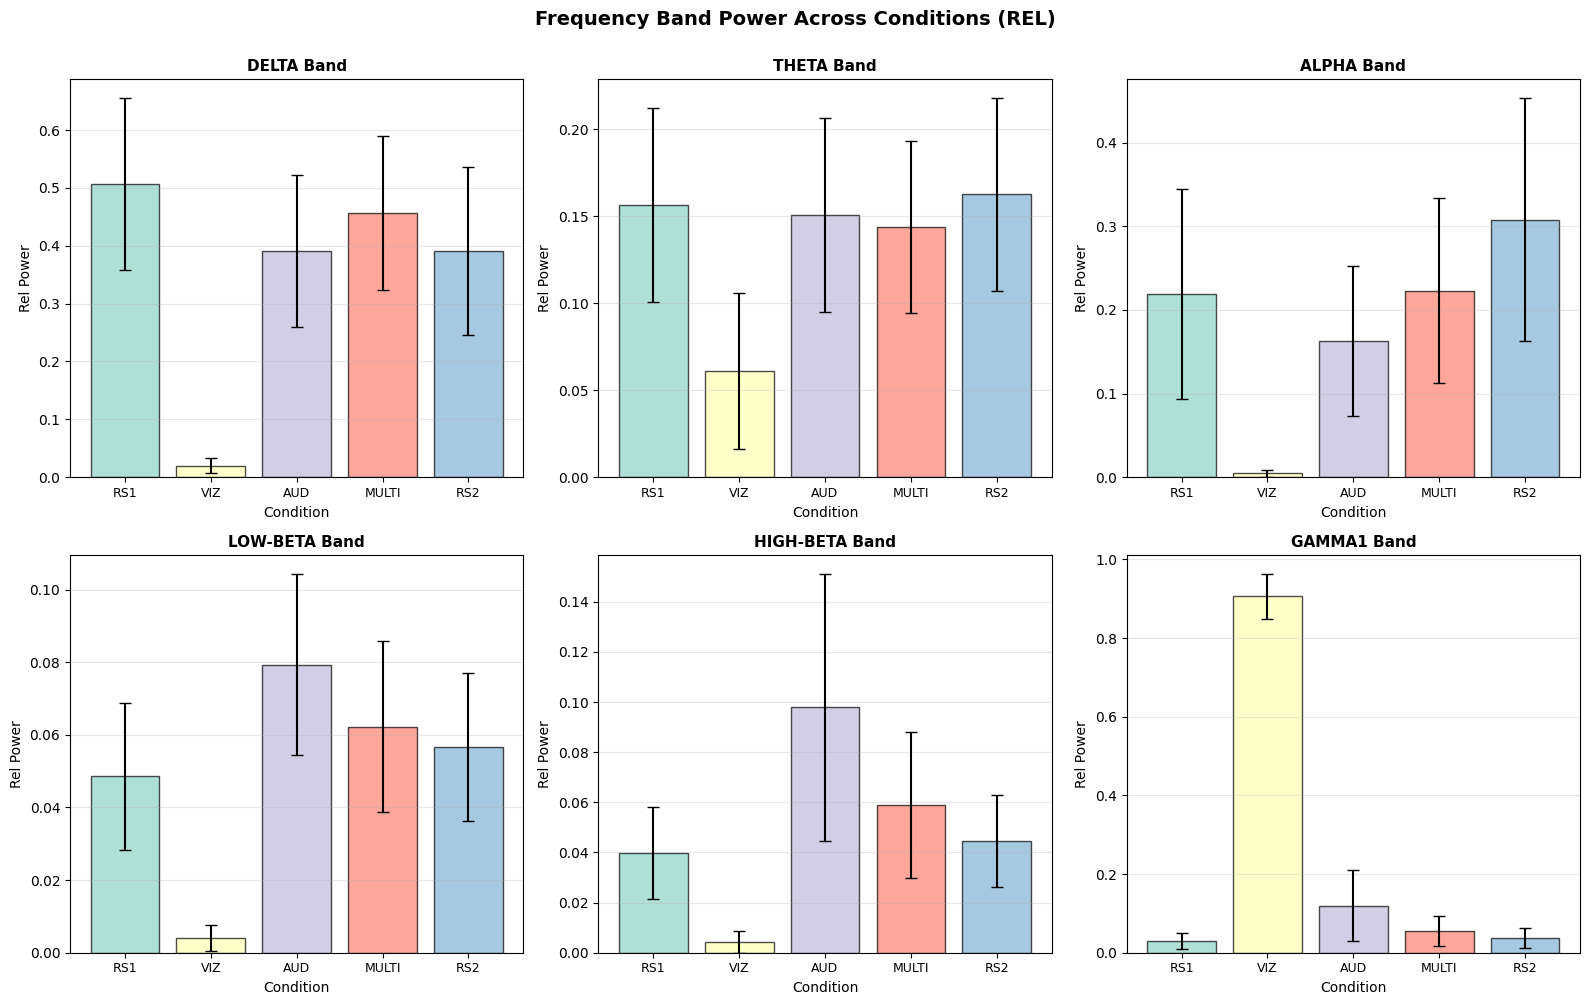

In [ ]:


def plot_all_bands_comparison(features_dict, power_type='rel', channels=None):
    """
    Plot all frequency bands in subplots for comparison across conditions.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
    power_type : str
        'abs' or 'rel' (default: 'rel')
    channels : list or None
        List of channels to include, or None for all channels
    """
    
    bands = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1']
    conditions = list(features_dict.keys())
    colors = plt.cm.Set3(range(len(conditions)))
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, band in enumerate(bands):
        ax = axes[idx]
        column_name = f'{band}_{power_type}'
        
        means = []
        stds = []
        
        for cond in conditions:
            df = features_dict[cond]
            if channels is not None:
                df = df[df['channel'].isin(channels)]
            
            means.append(df[column_name].mean())
            stds.append(df[column_name].std())
        
        x_pos = np.arange(len(conditions))
        ax.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, 
               capsize=4, edgecolor='black', linewidth=1)
        
        ax.set_xlabel('Condition', fontsize=10)
        ax.set_ylabel(f'{power_type.capitalize()} Power', fontsize=10)
        ax.set_title(f'{band.upper().replace("_", "-")} Band', fontsize=11, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(conditions, fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'Frequency Band Power Across Conditions ({power_type.upper()})', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


# Example usage:

plot_all_bands_comparison(features_dict, power_type='rel')

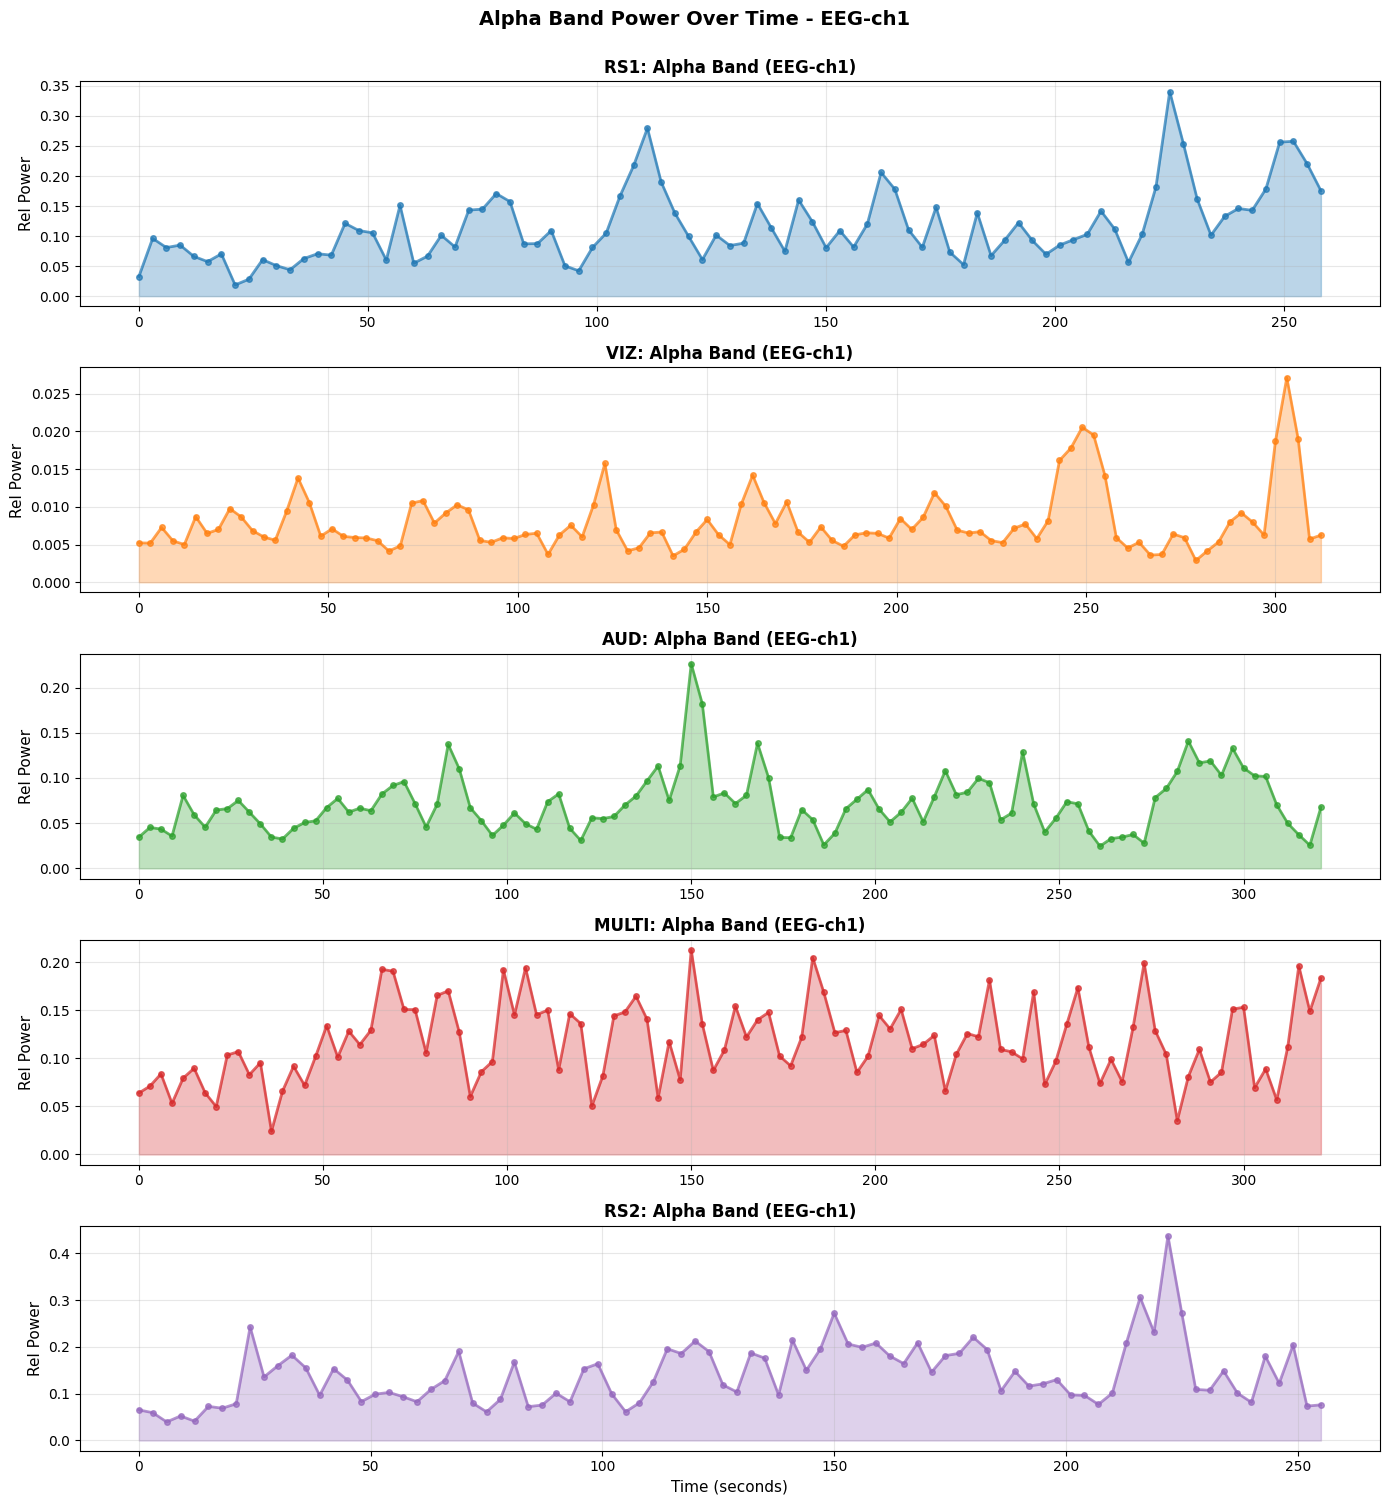

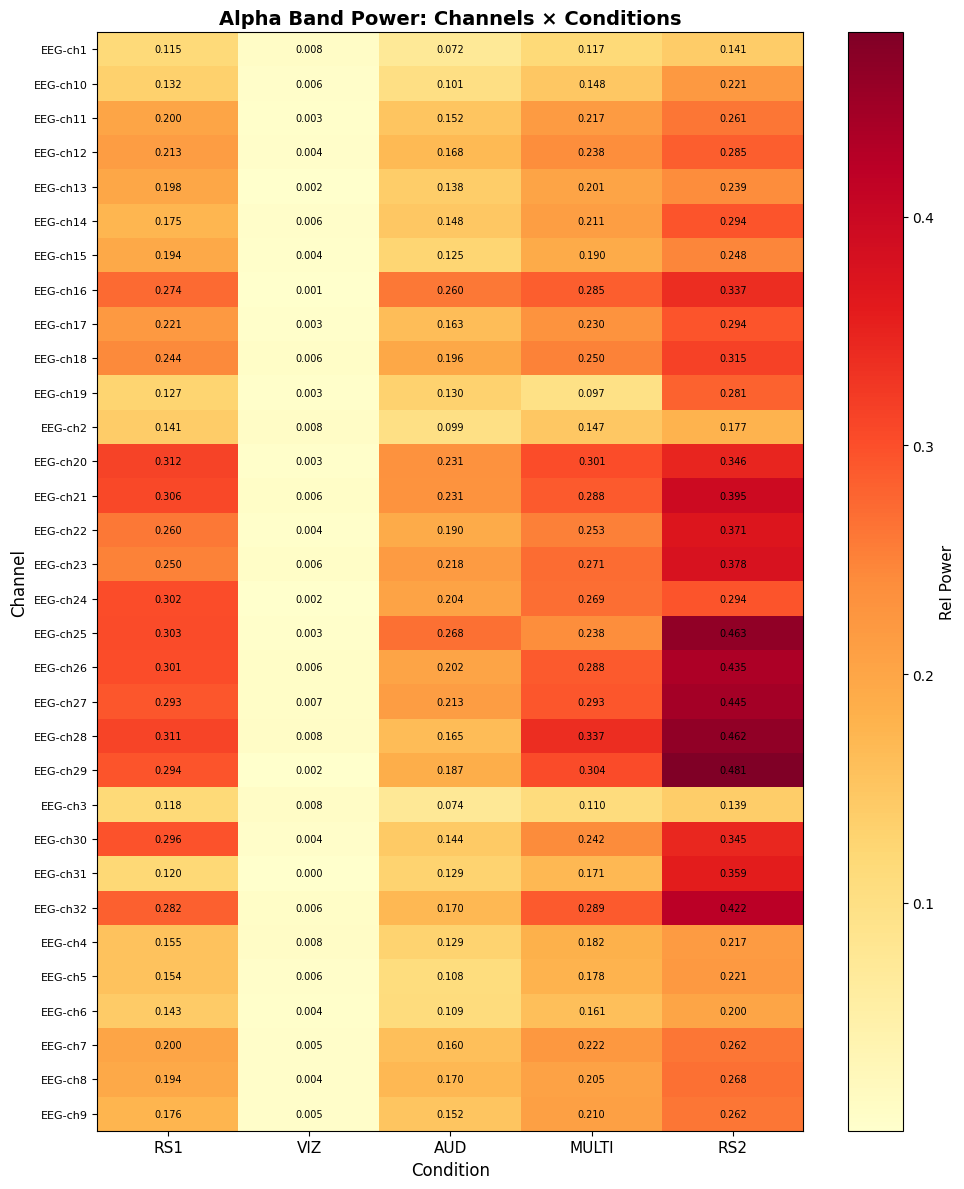

In [47]:
def plot_timeseries_by_condition(features_dict, band='alpha', power_type='rel', channel='EEG-ch1'):
    """
    Plot time series of band power evolution within each condition.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
    band : str
        Frequency band to plot (default: 'alpha')
    power_type : str
        'abs' or 'rel' (default: 'rel')
    channel : str
        Channel to plot (default: 'EEG-ch1')
    """
    
    fig, axes = plt.subplots(len(features_dict), 1, figsize=(14, 3*len(features_dict)), sharex=False)
    
    if len(features_dict) == 1:
        axes = [axes]
    
    column_name = f'{band}_{power_type}'
    colors = plt.cm.tab10(range(len(features_dict)))
    
    for idx, (cond_name, df) in enumerate(features_dict.items()):
        ax = axes[idx]
        
        # Filter for specific channel
        df_ch = df[df['channel'] == channel].sort_values('window_idx')
        
        # Plot time series
        ax.plot(df_ch['time_start'], df_ch[column_name], 
                linewidth=2, color=colors[idx], marker='o', markersize=4, alpha=0.7)
        ax.fill_between(df_ch['time_start'], df_ch[column_name], 
                        alpha=0.3, color=colors[idx])
        
        ax.set_ylabel(f'{power_type.capitalize()} Power', fontsize=11)
        ax.set_title(f'{cond_name}: {band.capitalize()} Band ({channel})', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if idx == len(features_dict) - 1:
            ax.set_xlabel('Time (seconds)', fontsize=11)
    
    plt.suptitle(f'{band.capitalize()} Band Power Over Time - {channel}', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


def plot_heatmap_conditions(features_dict, band='alpha', power_type='rel'):
    """
    Heatmap showing band power across channels and conditions.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
    band : str
        Frequency band to plot (default: 'alpha')
    power_type : str
        'abs' or 'rel' (default: 'rel')
    """
    
    column_name = f'{band}_{power_type}'
    conditions = list(features_dict.keys())
    
    # Get all channels from first condition
    channels = sorted(features_dict[conditions[0]]['channel'].unique())
    
    # Create matrix: channels × conditions
    matrix = np.zeros((len(channels), len(conditions)))
    
    for j, cond in enumerate(conditions):
        df = features_dict[cond]
        for i, ch in enumerate(channels):
            df_ch = df[df['channel'] == ch]
            matrix[i, j] = df_ch[column_name].mean()
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 12))
    im = ax.imshow(matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    
    # Set ticks
    ax.set_xticks(np.arange(len(conditions)))
    ax.set_yticks(np.arange(len(channels)))
    ax.set_xticklabels(conditions, fontsize=11)
    ax.set_yticklabels(channels, fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'{power_type.capitalize()} Power', fontsize=11)
    
    # Add values in cells
    for i in range(len(channels)):
        for j in range(len(conditions)):
            text = ax.text(j, i, f'{matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=7)
    
    ax.set_xlabel('Condition', fontsize=12)
    ax.set_ylabel('Channel', fontsize=12)
    ax.set_title(f'{band.capitalize()} Band Power: Channels × Conditions', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Example usage:
plot_timeseries_by_condition(features_dict, band='alpha', power_type='rel', channel='EEG-ch1')
plot_heatmap_conditions(features_dict, band='alpha', power_type='rel')

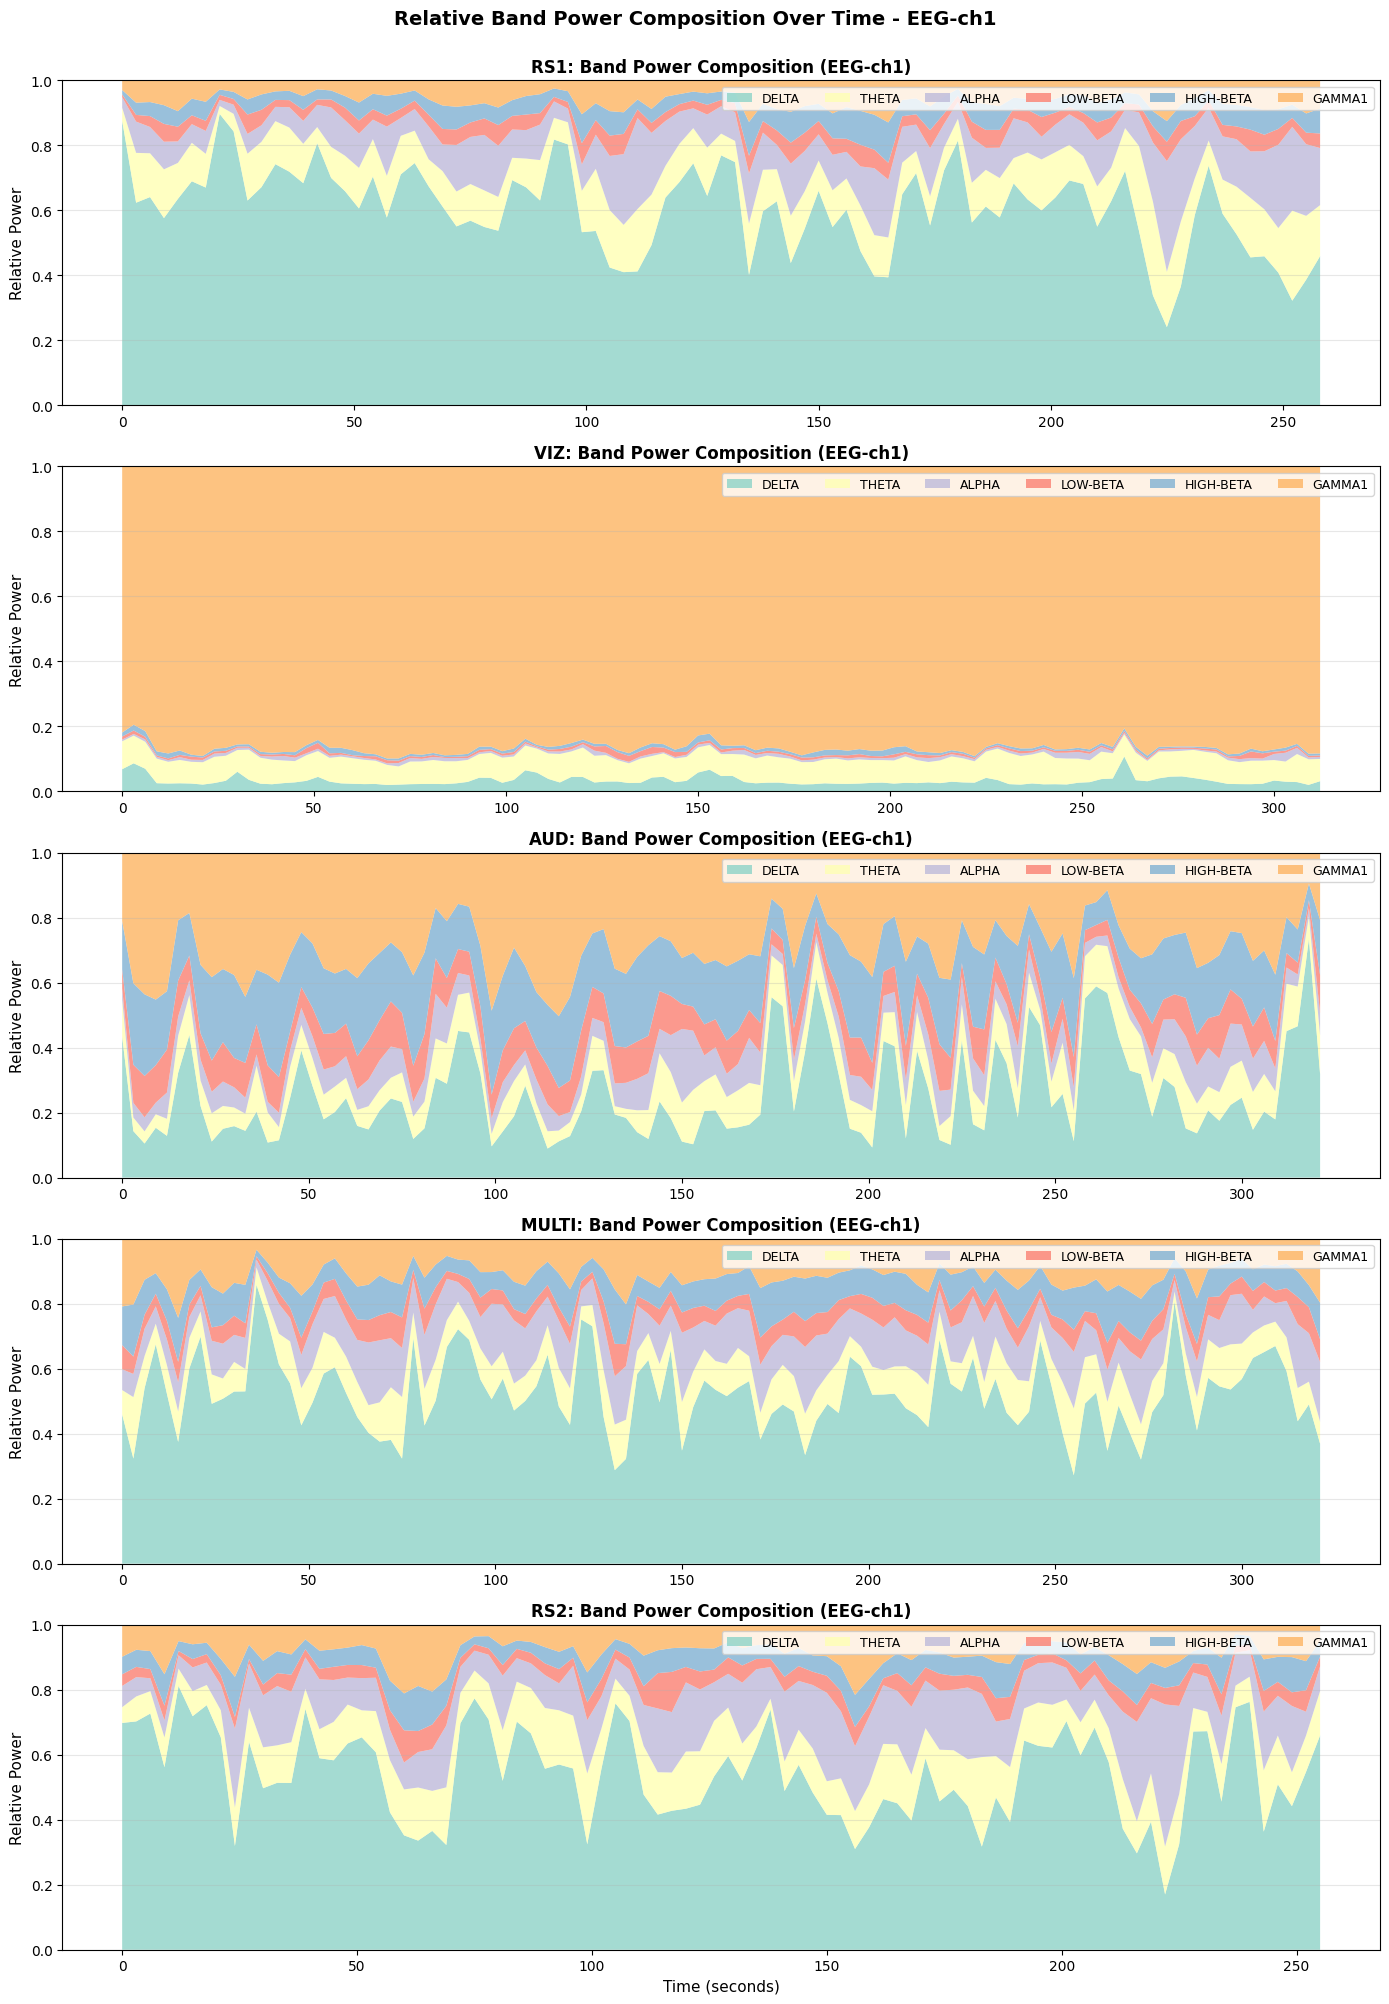

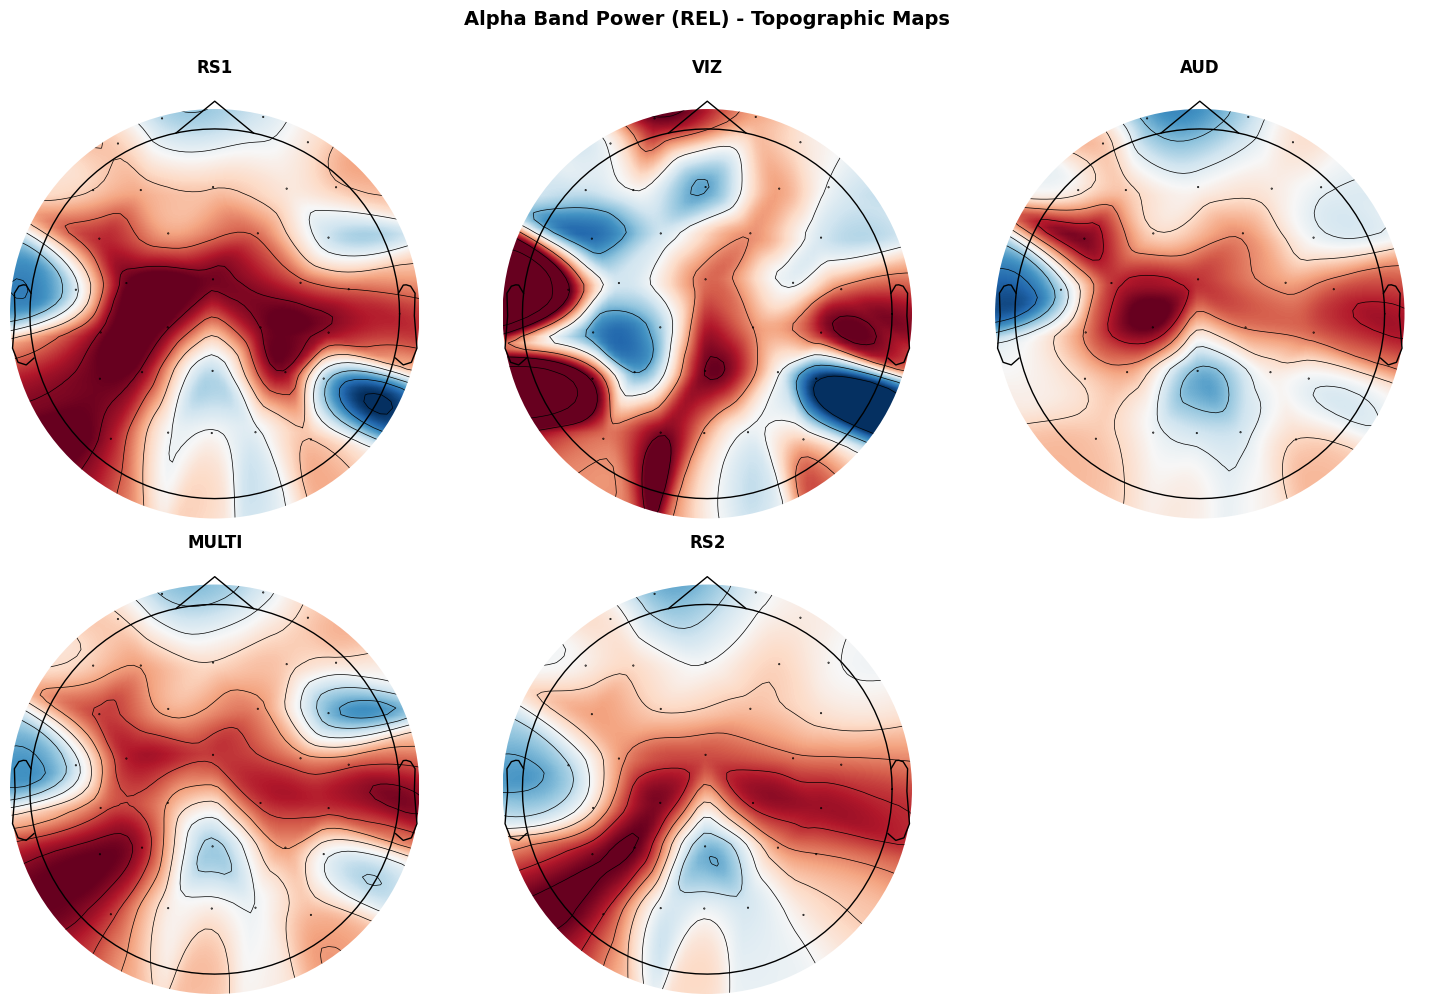

In [49]:
def plot_stacked_area_conditions(features_dict, channel='EEG-ch1'):
    """
    Stacked area plot showing relative band composition over time for each condition.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
    channel : str
        Channel to plot (default: 'EEG-ch1')
    """
    
    bands = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1']
    conditions = list(features_dict.keys())
    
    fig, axes = plt.subplots(len(conditions), 1, figsize=(14, 4*len(conditions)), sharex=False)
    
    if len(conditions) == 1:
        axes = [axes]
    
    colors = plt.cm.Set3(range(len(bands)))
    
    for idx, (cond_name, df) in enumerate(features_dict.items()):
        ax = axes[idx]
        
        # Filter for specific channel and sort by time
        df_ch = df[df['channel'] == channel].sort_values('window_idx')
        
        # Prepare data for stacking
        time = df_ch['time_start'].values
        band_data = np.array([df_ch[f'{band}_rel'].values for band in bands])
        
        # Create stacked area plot
        ax.stackplot(time, band_data, labels=[b.upper().replace('_', '-') for b in bands], 
                    colors=colors, alpha=0.8)
        
        ax.set_ylabel('Relative Power', fontsize=11)
        ax.set_title(f'{cond_name}: Band Power Composition ({channel})', 
                    fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(loc='upper right', fontsize=9, ncol=6)
        
        if idx == len(conditions) - 1:
            ax.set_xlabel('Time (seconds)', fontsize=11)
    
    plt.suptitle(f'Relative Band Power Composition Over Time - {channel}', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


def plot_topomaps_by_condition(features_dict, band='alpha', power_type='rel'):
    """
    Topographic maps showing spatial distribution of band power for each condition.
    Requires MNE-Python.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
    band : str
        Frequency band to plot (default: 'alpha')
    power_type : str
        'abs' or 'rel' (default: 'rel')
    """
    
    import mne
    
    column_name = f'{band}_{power_type}'
    conditions = list(features_dict.keys())
    
    # Get channels
    channels = sorted(features_dict[conditions[0]]['channel'].unique())
    n_channels = len(channels)
    
    # Create MNE-compatible channel names
    standard_32_channels = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'FC5', 'FC1', 'FC2', 'FC6',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'CP5', 'CP1', 'CP2', 'CP6',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'PO9', 'O1', 'Oz', 'O2', 'PO10',
        'AF7', 'AF8'
    ]
    
    mne_ch_names = standard_32_channels[:n_channels]
    
    # Create MNE Info object
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=mne_ch_names, sfreq=256, ch_types='eeg')
    info.set_montage(montage)
    
    # Create figure
    n_cols = min(3, len(conditions))
    n_rows = int(np.ceil(len(conditions) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    if len(conditions) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot each condition
    for idx, cond in enumerate(conditions):
        df = features_dict[cond]
        
        # Calculate average power per channel
        channel_power = []
        for ch in channels:
            df_ch = df[df['channel'] == ch]
            channel_power.append(df_ch[column_name].mean())
        
        channel_power = np.array(channel_power)
        
        # Plot topomap
        im, _ = mne.viz.plot_topomap(
            channel_power,
            info,
            axes=axes[idx],
            show=False,
            cmap='RdBu_r',
            contours=6
        )
        axes[idx].set_title(f'{cond}', fontsize=12, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(len(conditions), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{band.capitalize()} Band Power ({power_type.upper()}) - Topographic Maps', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_stacked_area_conditions(features_dict, channel='EEG-ch1')
plot_topomaps_by_condition(features_dict, band='alpha', power_type='rel')


AUD vs VIZ:
  Significant channels (p < 0.05): 32/32
  T-statistic range: [13.95, 23.40]
  Effect size (percent) range: [0.0650, 0.2630]

AUD vs MULTI:
  Significant channels (p < 0.05): 30/32
  T-statistic range: [-9.13, 2.49]
  Effect size (percent) range: [-0.1712, 0.0280]

VIZ vs MULTI:
  Significant channels (p < 0.05): 32/32
  T-statistic range: [-24.73, -11.83]
  Effect size (percent) range: [-0.3286, -0.0967]


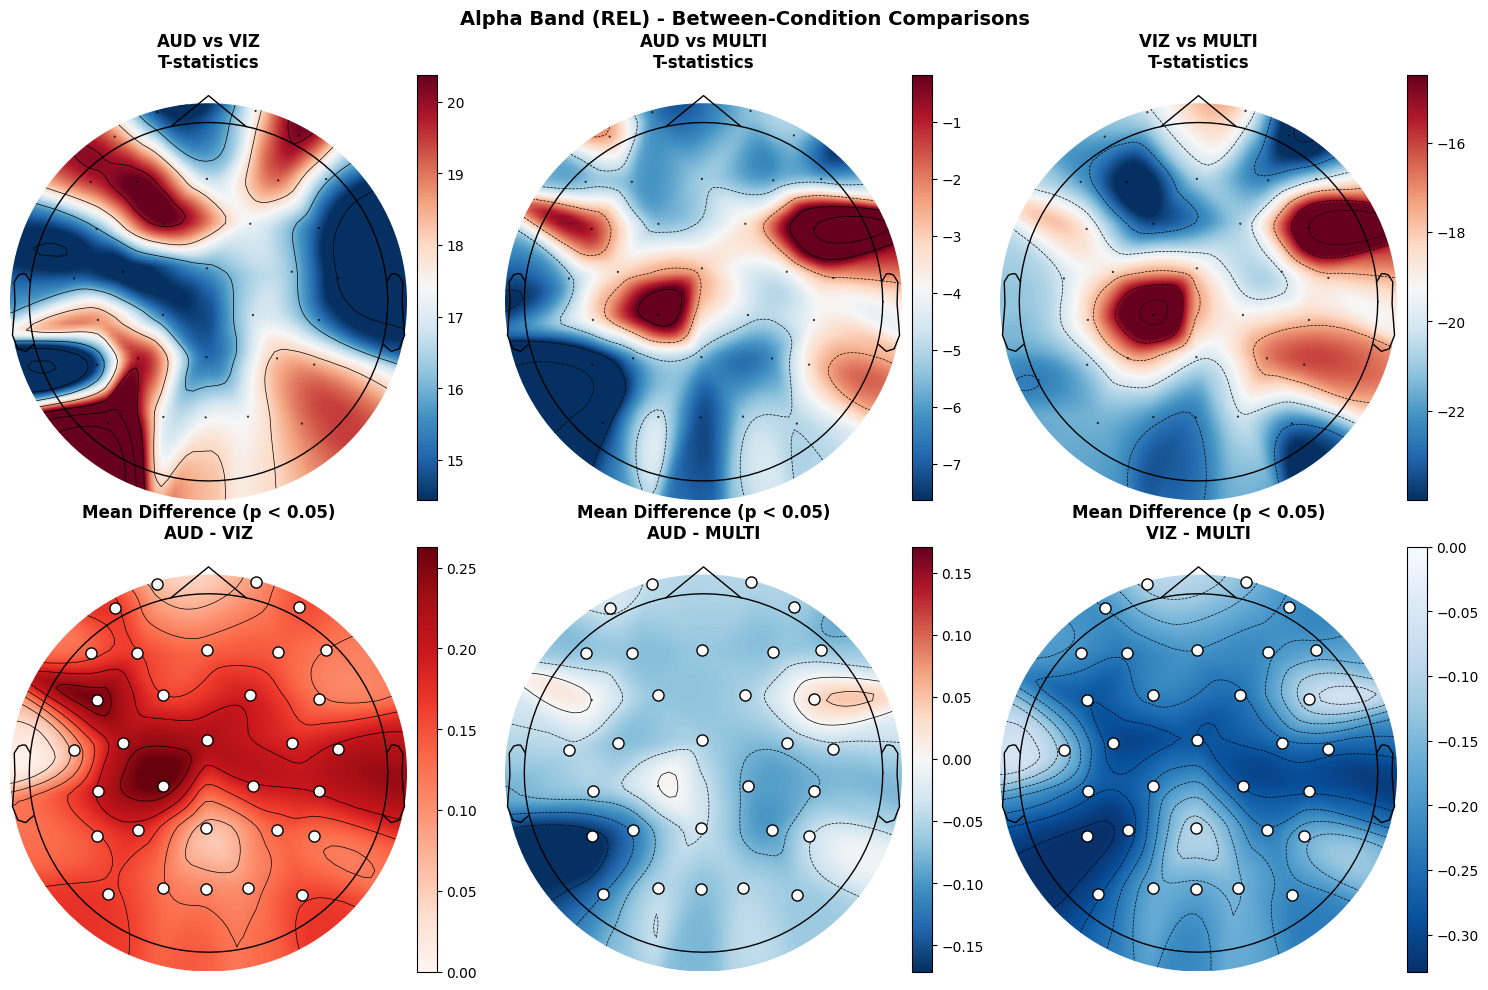

In [70]:
from scipy import stats

def compare_conditions_ttest(features_dict, band='alpha', power_type='rel', comparisons=None, effect_size='cohens_d'):
    """
    Perform t-tests comparing conditions and visualize results as topomaps.
    
    Parameters
    ----------
    features_dict : dict
        Dictionary with condition names as keys and feature dataframes as values
        e.g., {'AUD': features_aud, 'VIZ': features_viz, 'MULTI': features_multi}
    band : str
        Frequency band to analyze (default: 'alpha')
    power_type : str
        'abs' or 'rel' (default: 'rel')
    comparisons : list of tuples or None
        List of condition pairs to compare, e.g., [('AUD', 'VIZ'), ('AUD', 'MULTI')]
        If None, will compare all pairs (default: None)
    effect_size : str
        Type of effect size to plot: 'cohens_d' (default), 'raw_diff', 'percent_change'
    
    Returns
    -------
    results : dict
        Dictionary with comparison names as keys and results as values
    """
    
    import mne
    
    column_name = f'{band}_{power_type}'
    conditions = list(features_dict.keys())
    
    # Get channels from first condition
    channels = sorted(features_dict[conditions[0]]['channel'].unique())
    n_channels = len(channels)
    
    # Create MNE-compatible channel names
    standard_32_channels = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'FC5', 'FC1', 'FC2', 'FC6',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'CP5', 'CP1', 'CP2', 'CP6',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'PO9', 'O1', 'Oz', 'O2', 'PO10',
        'AF7', 'AF8'
    ]
    
    mne_ch_names = standard_32_channels[:n_channels]
    
    # Create MNE Info object
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=mne_ch_names, sfreq=256, ch_types='eeg')
    info.set_montage(montage)
    
    # Define comparisons
    if comparisons is None:
        # Generate all pairwise comparisons
        from itertools import combinations
        comparisons = list(combinations(conditions, 2))
    
    # Storage for results
    results = {}
    
    # Perform t-tests for each comparison
    for cond1, cond2 in comparisons:
        if cond1 not in features_dict or cond2 not in features_dict:
            print(f"Warning: {cond1} or {cond2} not found in features_dict")
            continue
        
        print(f"\n{cond1} vs {cond2}:")
        
        df1 = features_dict[cond1]
        df2 = features_dict[cond2]
        
        t_stats = []
        p_values = []
        mean_diffs = []
        effect_sizes = []
        
        for ch in channels:
            # Get all window values for this channel in each condition
            values1 = df1[df1['channel'] == ch][column_name].values
            values2 = df2[df2['channel'] == ch][column_name].values
            
            # Perform independent samples t-test
            t_stat, p_val = stats.ttest_ind(values1, values2)
            
            # Calculate effect size
            mean1, mean2 = values1.mean(), values2.mean()
            std1, std2 = values1.std(), values2.std()
            n1, n2 = len(values1), len(values2)
            
            # Raw difference
            raw_diff = mean1 - mean2
            
            # Cohen's d (pooled standard deviation)
            pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
            cohens_d = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
            
            # Percent change
            percent_change = (mean1 - mean2) / mean2 * 100 if mean2 != 0 else 0
            
            t_stats.append(t_stat)
            p_values.append(p_val)
            mean_diffs.append(raw_diff)
            
            if effect_size == 'cohens_d':
                effect_sizes.append(cohens_d)
            elif effect_size == 'percent_change':
                effect_sizes.append(percent_change)
            else:  # raw_diff
                effect_sizes.append(raw_diff)
        
        t_stats = np.array(t_stats)
        p_values = np.array(p_values)
        mean_diffs = np.array(mean_diffs)
        effect_sizes = np.array(effect_sizes)
        
        # Store results
        results[f'{cond1}_vs_{cond2}'] = {
            't_stats': t_stats,
            'p_values': p_values,
            'mean_diffs': mean_diffs,
            'effect_sizes': effect_sizes,
            'effect_type': effect_size,
            'channels': channels
        }
        
        # Print summary
        n_sig = (p_values < 0.05).sum()
        print(f"  Significant channels (p < 0.05): {n_sig}/{len(channels)}")
        print(f"  T-statistic range: [{t_stats.min():.2f}, {t_stats.max():.2f}]")
        print(f"  Effect size ({effect_size}) range: [{effect_sizes.min():.4f}, {effect_sizes.max():.4f}]")
        
        if effect_size == 'cohens_d':
            # Provide interpretation
            large_effects = np.abs(effect_sizes) > 0.8
            medium_effects = (np.abs(effect_sizes) > 0.5) & (np.abs(effect_sizes) <= 0.8)
            print(f"  Large effects (|d| > 0.8): {large_effects.sum()} channels")
            print(f"  Medium effects (|d| > 0.5): {medium_effects.sum()} channels")
    
    # Create figure with topomaps
    n_comparisons = len(comparisons)
    fig, axes = plt.subplots(2, n_comparisons, figsize=(5*n_comparisons, 10))
    
    if n_comparisons == 1:
        axes = axes.reshape(2, 1)
    
    for idx, (cond1, cond2) in enumerate(comparisons):
        comp_key = f'{cond1}_vs_{cond2}'
        if comp_key not in results:
            continue
        
        t_stats = results[comp_key]['t_stats']
        p_values = results[comp_key]['p_values']
        effect_sizes = results[comp_key]['effect_sizes']
        
        # Plot 1: T-statistics
        im1, _ = mne.viz.plot_topomap(
            t_stats,
            info,
            axes=axes[0, idx],
            show=False,
            cmap='RdBu_r',
            contours=6,
            vlim=(np.percentile(t_stats, 5), np.percentile(t_stats, 95))
        )
        axes[0, idx].set_title(f'{cond1} vs {cond2}\nT-statistics', fontsize=12, fontweight='bold')
        
        # Add colorbar for t-stats
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider1 = make_axes_locatable(axes[0, idx])
        cax1 = divider1.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im1, cax=cax1)
        
        # Plot 2: Effect size masked by significance
        sig_mask = p_values < 0.05
        masked_effects = effect_sizes.copy()
        masked_effects[~sig_mask] = 0
        
        # Choose colormap: diverging if effects go both ways, sequential if one-directional
        sig_effects = effect_sizes[sig_mask]
        if len(sig_effects) > 0 and (sig_effects.min() * sig_effects.max() < 0):
            # Effects in both directions: use diverging, centered at 0
            cmap = 'RdBu_r'
            vlim = max(abs(masked_effects.min()), abs(masked_effects.max()))
            if vlim == 0:
                vlim = 1e-6  # Avoid zero vlim
            vlim_tuple = (-vlim, vlim)
        else:
            # All same direction: use sequential colormap
            nonzero_effects = masked_effects[masked_effects != 0]
            if len(nonzero_effects) > 0 and nonzero_effects.mean() > 0:
                cmap = 'Reds'  # Positive effects
                vlim_tuple = (0, masked_effects.max() if masked_effects.max() > 0 else 1e-6)
            elif len(nonzero_effects) > 0:
                cmap = 'Blues_r'  # Negative effects
                vlim_tuple = (masked_effects.min() if masked_effects.min() < 0 else -1e-6, 0)
            else:
                # No significant effects, use default
                cmap = 'RdBu_r'
                vlim_tuple = (-1e-6, 1e-6)
        
        im2, _ = mne.viz.plot_topomap(
            masked_effects,
            info,
            axes=axes[1, idx],
            show=False,
            cmap=cmap,
            vlim=vlim_tuple,
            contours=6,
            mask=sig_mask,
            mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                           linewidth=0, markersize=8)
        )
        
        # Label based on effect size type
        if effect_size == 'cohens_d':
            effect_label = "Cohen's d"
        elif effect_size == 'percent_change':
            effect_label = "% Change"
        else:
            effect_label = "Mean Difference"
        
        axes[1, idx].set_title(f'{effect_label} (p < 0.05)\n{cond1} - {cond2}', 
                              fontsize=12, fontweight='bold')
        
        # Add colorbar for mean diff
        divider2 = make_axes_locatable(axes[1, idx])
        cax2 = divider2.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im2, cax=cax2)
    
    plt.suptitle(f'{band.capitalize()} Band ({power_type.upper()}) - Between-Condition Comparisons', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    return results


# Example usage:
comparisons = [('AUD', 'VIZ'), ('AUD', 'MULTI'), ('VIZ', 'MULTI')]
results = compare_conditions_ttest(features_dict, band='alpha', power_type='rel', comparisons=comparisons, effect_size='percent')

channel  window_idx  time_start  time_end   delta_abs  theta_abs  \
0      EEG-ch1           0         0.0       5.0  128.090566   8.891843   
1      EEG-ch2           0         0.0       5.0   84.349741   7.617120   
2      EEG-ch3           0         0.0       5.0  120.155869   9.948490   
3      EEG-ch4           0         0.0       5.0   50.447593   9.485714   
4      EEG-ch5           0         0.0       5.0   49.781044   9.756836   
...        ...         ...         ...       ...         ...        ...   
2747  EEG-ch28          85       255.0     260.0   25.297627   7.408551   
2748  EEG-ch29          85       255.0     260.0   42.771722  19.374494   
2749  EEG-ch30          85       255.0     260.0  251.719606  56.908094   
2750  EEG-ch31          85       255.0     260.0   40.174120  15.244194   
2751  EEG-ch32          85       255.0     260.0   25.695161  14.149665   

      alpha_abs  low_beta_abs  high_beta_abs  gamma1_abs  delta_rel  \
0     12.006632      6.552489       9.930082   18.099251   0.697772   
1     10.514635      4.178369       6.037285   10.759642   0.683233   
2     10.489334      4.694995       6.913517   12.000698   0.731752   
3     12.330942      4.110283       4.654344    7.333377   0.570918   
4     10.712674      3.852581       4.026457    6.482499   0.588344   
...         ...           ...            ...         ...        ...   
2747  18.769424      4.554029       3.175293    2.901759   0.407325   
2748  33.701167      6.601712       5.800971    3.312838   0.383387   
2749  57.332218     17.553103       8.863830   22.434051   0.606830   
2750  33.537840     10.887453       7.142881    5.241545   0.357969   
2751  33.847527      8.066476       5.651656    3.575767   0.282407   

      theta_rel  alpha_rel  low_beta_rel  high_beta_rel  gamma1_rel  
0      0.048438   0.065406      0.035695       0.054094    0.098595  
1      0.061699   0.085169      0.033845       0.048902    0.087153  
2      0.060587   0.063880      0.028593       0.042103    0.073085  
3      0.107350   0.139550      0.046516       0.052673    0.082992  
4      0.115313   0.126609      0.045532       0.047587    0.076614  
...         ...        ...           ...            ...         ...  
2747   0.119288   0.302213      0.073326       0.051126    0.046722  
2748   0.173664   0.302082      0.059175       0.051997    0.029695  
2749   0.137190   0.138213      0.042316       0.021368    0.054083  
2750   0.135832   0.298837      0.097012       0.063646    0.046704  
2751   0.155514   0.372007      0.088656       0.062115    0.039300  

[2752 rows x 16 columns]

## Compute power spectral density (PSD) for EEG data across time

### Plot all frequency bands for one contrast

delta: min p=1.93e-80, max p=4.13e-42, 32/32 uncorrected p<0.05, 32/32 FDR at alpha=0.01
theta: min p=2.49e-62, max p=8.79e-02, 31/32 uncorrected p<0.05, 31/32 FDR at alpha=0.01
alpha: min p=3.46e-50, max p=3.54e-22, 32/32 uncorrected p<0.05, 32/32 FDR at alpha=0.01
low_beta: min p=5.00e-66, max p=4.96e-27, 32/32 uncorrected p<0.05, 32/32 FDR at alpha=0.01
high_beta: min p=8.28e-59, max p=2.97e-20, 32/32 uncorrected p<0.05, 32/32 FDR at alpha=0.01
gamma1: min p=2.67e-218, max p=1.86e-134, 32/32 uncorrected p<0.05, 32/32 FDR at alpha=0.01


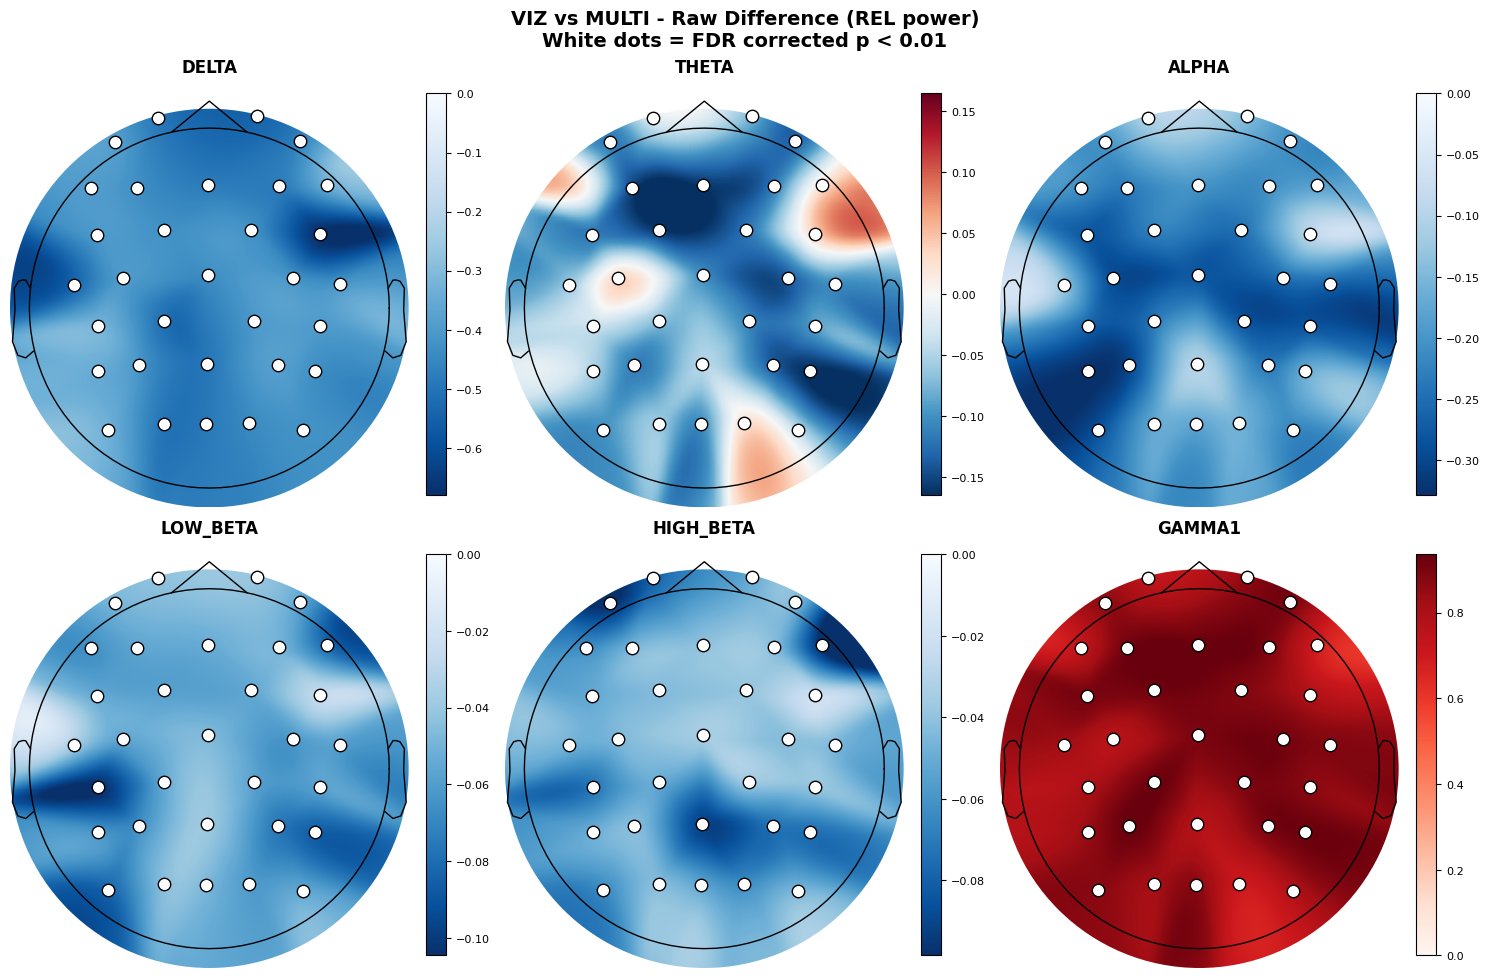

In [ ]:
def plot_all_bands_contrast(features_dict, cond1, cond2, power_type='rel', effect_size='cohens_d', alpha=0.05):
    """
    Plot effect sizes across all 6 frequency bands for a single contrast.
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary with condition names as keys and DataFrames as values
    cond1 : str
        Name of first condition
    cond2 : str
        Name of second condition
    power_type : str
        'abs' for absolute power or 'rel' for relative power
    effect_size : str
        Type of effect size: 'cohens_d' (default), 'raw_diff', or 'percent_change'
    alpha : float
        Significance threshold for FDR correction (default: 0.05)
    """
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests
    import matplotlib.pyplot as plt
    import mne
    
    bands = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1']
    
    # Create figure with 2 rows x 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Get channels from first condition
    df_sample = features_dict[cond1]
    channels = sorted(df_sample['channel'].unique())
    n_channels = len(channels)
    
    # Create MNE-compatible channel names
    standard_32_channels = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'FC5', 'FC1', 'FC2', 'FC6',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'CP5', 'CP1', 'CP2', 'CP6',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'PO9', 'O1', 'Oz', 'O2', 'PO10',
        'AF7', 'AF8'
    ]
    
    mne_ch_names = standard_32_channels[:n_channels]
    
    # Create MNE Info object
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=mne_ch_names, sfreq=256, ch_types='eeg')
    info.set_montage(montage)
    
    for idx, band in enumerate(bands):
        # Get data for both conditions
        power_col = f'{band}_{power_type}'
        
        df1 = features_dict[cond1]
        df2 = features_dict[cond2]
        
        # Arrays to store results
        t_stats = []
        p_values = []
        effect_sizes_arr = []
        
        # Perform t-test for each channel
        for ch in channels:
            data1 = df1[df1['channel'] == ch][power_col].values
            data2 = df2[df2['channel'] == ch][power_col].values
            
            # Perform independent samples t-test
            t_stat, p_val = ttest_ind(data1, data2)
            t_stats.append(t_stat)
            p_values.append(p_val)
            
            # Calculate effect size
            if effect_size == 'cohens_d':
                # Cohen's d with pooled standard deviation
                n1, n2 = len(data1), len(data2)
                s1, s2 = np.std(data1, ddof=1), np.std(data2, ddof=1)
                pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
                effect = (np.mean(data1) - np.mean(data2)) / pooled_std if pooled_std > 0 else 0
            elif effect_size == 'percent_change':
                mean1, mean2 = np.mean(data1), np.mean(data2)
                effect = ((mean1 - mean2) / mean2 * 100) if mean2 != 0 else 0
            else:  # raw_diff
                effect = np.mean(data1) - np.mean(data2)
            
            effect_sizes_arr.append(effect)
        
        effect_sizes_arr = np.array(effect_sizes_arr)
        p_values = np.array(p_values)
        
        # Apply FDR correction
        reject_fdr, p_values_fdr, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
        
        # Create mask for FDR-corrected significance
        mask = reject_fdr
        masked_effects = effect_sizes_arr.copy()
        masked_effects[~mask] = 0  # Set non-significant to 0
        
        # Determine colormap based on effect directionality
        if len(masked_effects[mask]) > 0:
            sig_effects = masked_effects[mask]
            has_positive = np.any(sig_effects > 0)
            has_negative = np.any(sig_effects < 0)
            
            if has_positive and has_negative:
                # Mixed effects - use diverging colormap
                cmap = 'RdBu_r'
                max_abs = np.max(np.abs(masked_effects))
                vlim_tuple = (-max_abs, max_abs) if max_abs > 0 else (-1e-6, 1e-6)
            elif has_positive:
                # Only positive effects - use sequential warm
                cmap = 'Reds'
                max_val = np.max(masked_effects)
                vlim_tuple = (0, max_val) if max_val > 0 else (0, 1e-6)
            else:
                # Only negative effects - use sequential cool
                cmap = 'Blues_r'
                min_val = np.min(masked_effects)
                vlim_tuple = (min_val, 0) if min_val < 0 else (-1e-6, 0)
        else:
            # No significant effects
            cmap = 'RdBu_r'
            vlim_tuple = (-1e-6, 1e-6)
        
        # Plot topomap on the appropriate subplot
        im, contours = mne.viz.plot_topomap(
            masked_effects, 
            info,
            axes=axes[idx],
            show=False,
            cmap=cmap,
            vlim=vlim_tuple,
            contours=0,
            sensors=False  # Don't show default sensors
        )
        
        # Add significance markers (white dots) using MNE's position transformation
        if np.any(mask):
            # Use MNE's internal function to get properly transformed positions
            from mne.viz.topomap import _get_pos_outlines
            pos_xy, outlines = _get_pos_outlines(info, None, sphere=None)
            
            # Get significant channel positions
            sig_positions = pos_xy[mask]
            
            # Add white circles
            axes[idx].scatter(sig_positions[:, 0], sig_positions[:, 1], 
                            s=80, c='white', marker='o', edgecolors='black', 
                            linewidths=1, zorder=10)
        
        # Set title for each subplot
        axes[idx].set_title(f'{band.upper()}', fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    
    # Effect size label
    if effect_size == 'cohens_d':
        effect_label = "Cohen's d"
    elif effect_size == 'percent_change':
        effect_label = "% Change"
    else:
        effect_label = "Raw Difference"
    
    # Main title
    fig.suptitle(f'{cond1} vs {cond2} - {effect_label} ({power_type.upper()} power)\nWhite dots = FDR corrected p < {alpha}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()


# Example usage:
plot_all_bands_contrast(features_dict, 'VIZ', 'MULTI', power_type='rel', effect_size='cohen_d', alpha=0.01)

Processing 32 EEG channels
  Found 18784 NaN values across all EEG channels
  NaN proportion: 0.11%
  Worst channel: EEG-ch1 with 0.11% NaN
  Interpolating NaN values in EEG channels...
  NaN interpolation complete
Applying bandpass filter (0.5-50 Hz)...

DIAGNOSTIC: ECG contamination in FILTERED EEG (before ICA)...
  EEG-ch1: correlation = 0.0014
  EEG-ch2: correlation = 0.0008
  EEG-ch3: correlation = 0.0014
  EEG-ch4: correlation = 0.0008
  EEG-ch5: correlation = 0.0017
  EEG-ch6: correlation = 0.0001
  EEG-ch7: correlation = 0.0003
  EEG-ch8: correlation = 0.0000
  Maximum filtered correlation: EEG-ch5 = 0.0017
  ⚠️  WARNING: ECG contamination LOST after filtering!
  This explains why ICA cannot find ECG components.
  Consider widening the bandpass filter or checking if ECG artifact is in stopband.
Running ICA...
Identifying ECG components...
  ECG NaN count: 0 / 549948 (0.00%)
  ECG signal has no NaN values
  ECG signal stats: mean=-19476.11, std=2060.67, min=-23146.47, max=-13228

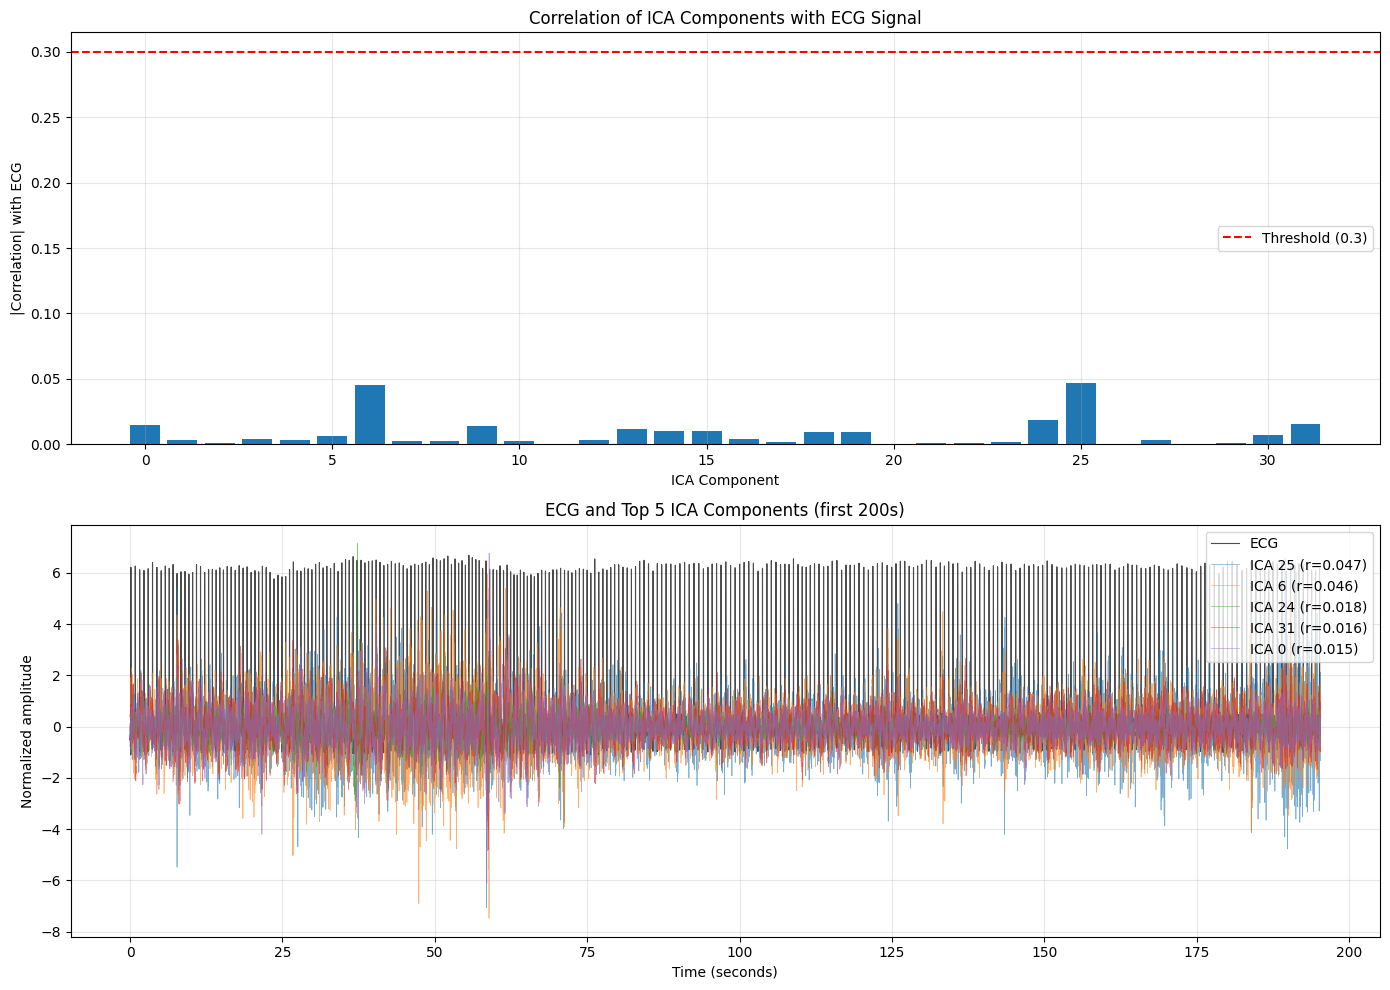


Found 0 ECG-related component(s) above threshold 0.3:
No significant ECG components found, using filtered data
Consider lowering the threshold or checking ECG signal quality
Preprocessing complete!


In [37]:
from scipy import signal
from sklearn.decomposition import FastICA

def preprocess_eeg(df, sampling_rate=256, lowcut=0.5, highcut=50, n_components=None, plot_components=True):
    """
    Preprocess EEG data with filtering and ICA-based ECG artifact removal.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with EEG channels and ECG
    sampling_rate : int
        Sampling rate in Hz (default: 256)
    lowcut : float
        Low cutoff frequency for bandpass filter (default: 0.5 Hz)
    highcut : float
        High cutoff frequency for bandpass filter (default: 50 Hz)
    n_components : int or None
        Number of ICA components (default: None = use number of EEG channels)
    plot_components : bool
        Whether to plot ICA components and correlations (default: True)
    
    Returns
    -------
    df_preprocessed : pd.DataFrame
        Preprocessed dataframe with filtered EEG and ECG artifacts removed
    """
    
    # Create a copy of the dataframe
    df_preprocessed = df.copy()
    
    # Get EEG channel names
    eeg_channels = [col for col in df.columns if col.startswith('EEG-ch')]
    print(f"Processing {len(eeg_channels)} EEG channels")
    
    # Extract EEG data
    eeg_data = df[eeg_channels].values  # Shape: (n_samples, n_channels)
    
    # Check for NaN values in EEG
    nan_mask = np.isnan(eeg_data)
    nan_count_per_channel = nan_mask.sum(axis=0)
    total_nans = nan_mask.sum()
    
    if total_nans > 0:
        print(f"  Found {total_nans} NaN values across all EEG channels")
        print(f"  NaN proportion: {100*total_nans/eeg_data.size:.2f}%")
        
        # Check if any channel has too many NaNs
        max_nan_channel = np.argmax(nan_count_per_channel)
        max_nan_proportion = nan_count_per_channel[max_nan_channel] / len(eeg_data)
        print(f"  Worst channel: {eeg_channels[max_nan_channel]} with {100*max_nan_proportion:.2f}% NaN")
        
        # Interpolate NaN values for each channel
        print("  Interpolating NaN values in EEG channels...")
        eeg_data_clean = eeg_data.copy()
        for i in range(eeg_data.shape[1]):
            channel_data = eeg_data[:, i]
            nan_indices = np.where(np.isnan(channel_data))[0]
            if len(nan_indices) > 0:
                valid_indices = np.where(~np.isnan(channel_data))[0]
                if len(valid_indices) > 0:
                    eeg_data_clean[nan_indices, i] = np.interp(nan_indices, valid_indices, channel_data[valid_indices])
                else:
                    # If entire channel is NaN, fill with zeros
                    eeg_data_clean[:, i] = 0
                    print(f"  WARNING: {eeg_channels[i]} is entirely NaN, filled with zeros")
        
        eeg_data = eeg_data_clean
        print("  NaN interpolation complete")
    else:
        print("  No NaN values found in EEG data")
    
    # 1. Bandpass filtering
    print(f"Applying bandpass filter ({lowcut}-{highcut} Hz)...")
    nyquist = sampling_rate / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    
    eeg_filtered = np.zeros_like(eeg_data)
    for i, ch in enumerate(eeg_channels):
        eeg_filtered[:, i] = signal.filtfilt(b, a, eeg_data[:, i])
    
    # DIAGNOSTIC: Check if ECG contamination survives filtering
    print("\nDIAGNOSTIC: ECG contamination in FILTERED EEG (before ICA)...")
    if 'ecg' in df.columns:
        ecg_signal_raw = df['ecg'].values
        # Filter ECG with same parameters
        if not np.all(np.isnan(ecg_signal_raw)):
            # Handle NaN in ECG
            valid_mask_ecg = ~np.isnan(ecg_signal_raw)
            if valid_mask_ecg.sum() > len(ecg_signal_raw) * 0.5:
                ecg_signal_for_diagnostic = ecg_signal_raw.copy()
                if valid_mask_ecg.sum() < len(ecg_signal_raw):
                    nan_indices = np.where(~valid_mask_ecg)[0]
                    valid_indices = np.where(valid_mask_ecg)[0]
                    ecg_signal_for_diagnostic[nan_indices] = np.interp(nan_indices, valid_indices, ecg_signal_raw[valid_indices])
                
                ecg_filtered_diagnostic = signal.filtfilt(b, a, ecg_signal_for_diagnostic)
                ecg_normalized_diagnostic = (ecg_filtered_diagnostic - np.mean(ecg_filtered_diagnostic)) / np.std(ecg_filtered_diagnostic)
                
                correlations_filtered = []
                for i, ch in enumerate(eeg_channels[:8]):
                    eeg_ch_filtered = eeg_filtered[:, i]
                    valid_mask_combined = ~np.isnan(eeg_ch_filtered) & ~np.isnan(ecg_normalized_diagnostic)
                    if valid_mask_combined.sum() > 100:
                        eeg_clean = eeg_ch_filtered[valid_mask_combined]
                        ecg_clean = ecg_normalized_diagnostic[valid_mask_combined]
                        eeg_norm = (eeg_clean - np.mean(eeg_clean)) / np.std(eeg_clean)
                        corr = np.abs(np.corrcoef(eeg_norm, ecg_clean)[0, 1])
                        correlations_filtered.append((ch, corr))
                        print(f"  {ch}: correlation = {corr:.4f}")
                
                if len(correlations_filtered) > 0:
                    max_corr_filtered = max(correlations_filtered, key=lambda x: x[1])
                    print(f"  Maximum filtered correlation: {max_corr_filtered[0]} = {max_corr_filtered[1]:.4f}")
                    if max_corr_filtered[1] < 0.1:
                        print("  ⚠️  WARNING: ECG contamination LOST after filtering!")
                        print("  This explains why ICA cannot find ECG components.")
                        print("  Consider widening the bandpass filter or checking if ECG artifact is in stopband.")
                    else:
                        print("  ✓ ECG contamination still present after filtering.")
    
    # 2. ICA for ECG artifact removal
    print("Running ICA...")
    if n_components is None:
        n_components = len(eeg_channels)
    
    # Standardize the data for ICA
    eeg_mean = np.mean(eeg_filtered, axis=0)
    eeg_std = np.std(eeg_filtered, axis=0)
    eeg_standardized = (eeg_filtered - eeg_mean) / eeg_std
    
    # Run ICA
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000)
    ica_sources = ica.fit_transform(eeg_standardized)  # Shape: (n_samples, n_components)
    
    # 3. Identify ECG component by correlation with ECG channel
    print("Identifying ECG components...")
    if 'ecg' in df.columns:
        ecg_signal = df['ecg'].values
        
        # Check for NaN values
        nan_count = np.isnan(ecg_signal).sum()
        print(f"  ECG NaN count: {nan_count} / {len(ecg_signal)} ({100*nan_count/len(ecg_signal):.2f}%)")
        
        # Handle NaN values by interpolation or removal
        if nan_count > 0:
            print(f"  Handling {nan_count} NaN values in ECG signal...")
            # Create a mask for valid (non-NaN) values
            valid_mask = ~np.isnan(ecg_signal)
            
            if valid_mask.sum() < len(ecg_signal) * 0.5:
                print("  WARNING: More than 50% of ECG signal is NaN!")
                print("  Skipping ECG artifact removal.")
                eeg_clean = eeg_filtered
                correlations = None
            else:
                # Interpolate NaN values using linear interpolation
                ecg_signal_clean = ecg_signal.copy()
                nan_indices = np.where(~valid_mask)[0]
                valid_indices = np.where(valid_mask)[0]
                ecg_signal_clean[nan_indices] = np.interp(nan_indices, valid_indices, ecg_signal[valid_indices])
                ecg_signal = ecg_signal_clean
                print(f"  Interpolated NaN values in ECG signal")
        else:
            print("  ECG signal has no NaN values")
        
        # Diagnostic checks for ECG signal (after NaN handling)
        if nan_count == 0 or (nan_count > 0 and valid_mask.sum() >= len(ecg_signal) * 0.5):
            print(f"  ECG signal stats: mean={np.mean(ecg_signal):.2f}, std={np.std(ecg_signal):.2f}, "
                  f"min={np.min(ecg_signal):.2f}, max={np.max(ecg_signal):.2f}")
            
            # Check if ECG has variance
            if np.std(ecg_signal) == 0:
                print("  WARNING: ECG signal is constant!")
                print("  Skipping ECG artifact removal.")
                eeg_clean = eeg_filtered
                correlations = None
            else:
                # Normalize ECG signal
                ecg_normalized = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
                
                # IMPORTANT: Apply same bandpass filter to ECG for fair comparison
                print(f"  Filtering ECG with same bandpass filter ({lowcut}-{highcut} Hz)...")
                ecg_filtered = signal.filtfilt(b, a, ecg_signal)
                ecg_normalized = (ecg_filtered - np.mean(ecg_filtered)) / np.std(ecg_filtered)
                
                # Calculate correlation between each ICA component and ECG
                correlations = np.zeros(n_components)
                for i in range(n_components):
                    correlations[i] = np.abs(np.corrcoef(ica_sources[:, i], ecg_normalized)[0, 1])
                
                # Plot correlation bar chart
                if plot_components:
                    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
                    
                    # Bar chart of correlations
                    axes[0].bar(range(n_components), correlations)
                    axes[0].axhline(y=0.3, color='r', linestyle='--', label='Threshold (0.3)')
                    axes[0].set_xlabel('ICA Component')
                    axes[0].set_ylabel('|Correlation| with ECG')
                    axes[0].set_title('Correlation of ICA Components with ECG Signal')
                    axes[0].legend()
                    axes[0].grid(True, alpha=0.3)
                    
                    # Show top 5 components
                    top_5_idx = np.argsort(correlations)[-5:][::-1]
                    print(f"\nTop 5 components by ECG correlation:")
                    for idx in top_5_idx:
                        print(f"  Component {idx}: correlation = {correlations[idx]:.3f}")
                    
                    # Plot top 5 ICA components vs ECG
                    time_seconds = np.arange(min(50000, len(ecg_signal))) / sampling_rate  # First ~200 seconds
                    axes[1].plot(time_seconds, ecg_normalized[:len(time_seconds)], 
                                linewidth=0.8, color='black', label='ECG', alpha=0.7)
                    
                    colors = plt.cm.tab10(range(5))
                    for i, idx in enumerate(top_5_idx):
                        axes[1].plot(time_seconds, ica_sources[:len(time_seconds), idx], 
                                   linewidth=0.5, alpha=0.6, label=f'ICA {idx} (r={correlations[idx]:.3f})',
                                   color=colors[i])
                    
                    axes[1].set_xlabel('Time (seconds)')
                    axes[1].set_ylabel('Normalized amplitude')
                    axes[1].set_title('ECG and Top 5 ICA Components (first 200s)')
                    axes[1].legend(loc='upper right')
                    axes[1].grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                
                # Find component(s) with highest correlation to ECG
                ecg_threshold = 0.3  # Threshold for considering a component as ECG-related
                ecg_components = np.where(correlations > ecg_threshold)[0]
                
                print(f"\nFound {len(ecg_components)} ECG-related component(s) above threshold {ecg_threshold}:")
                for comp_idx in ecg_components:
                    print(f"  Component {comp_idx}: correlation = {correlations[comp_idx]:.3f}")
                
                # 4. Remove ECG components and reconstruct
                if len(ecg_components) > 0:
                    print("Removing ECG components and reconstructing signal...")
                    # Zero out ECG components
                    ica_sources_clean = ica_sources.copy()
                    ica_sources_clean[:, ecg_components] = 0
                    
                    # Reconstruct the EEG data
                    eeg_reconstructed = ica.inverse_transform(ica_sources_clean)
                    
                    # Unstandardize
                    eeg_clean = (eeg_reconstructed * eeg_std) + eeg_mean
                else:
                    print("No significant ECG components found, using filtered data")
                    print("Consider lowering the threshold or checking ECG signal quality")
                    eeg_clean = eeg_filtered
        else:
            eeg_clean = eeg_filtered
            correlations = None
    else:
        print("Warning: No ECG channel found, skipping ECG artifact removal")
        eeg_clean = eeg_filtered
    
    # 5. Update the dataframe with preprocessed data
    for i, ch in enumerate(eeg_channels):
        df_preprocessed[ch] = eeg_clean[:, i]
    
    print("Preprocessing complete!")
    
    # Return additional info for further analysis
    if 'ecg' in df.columns:
        return df_preprocessed, ica, correlations, eeg_channels
    else:
        return df_preprocessed, ica, None, eeg_channels


# Example usage:
df_preprocessed, ica, correlations, eeg_channels = preprocess_eeg(df, sampling_rate=256, lowcut=0.5, highcut=50, plot_components=True)


### Key Finding: ECG Artifact Removed by High-Pass Filter

**Problem:** The 0.5 Hz high-pass filter removes ECG contamination before ICA can detect it.

**Evidence:**
- Raw EEG: 0.77 correlation with ECG (HIGH contamination)
- After 0.5-50 Hz filtering: 0.0017 correlation (contamination LOST)

**Solution:** Lower the high-pass cutoff to preserve cardiac artifacts:
- Try **0.1 Hz** instead of 0.5 Hz
- Cardiac artifacts have substantial energy below 0.5 Hz
- Trade-off: More slow drift, but ICA can remove ECG

**Alternative:** Do ICA on minimally filtered data (0.1 Hz), then apply stronger filtering (1 Hz) after artifact removal.

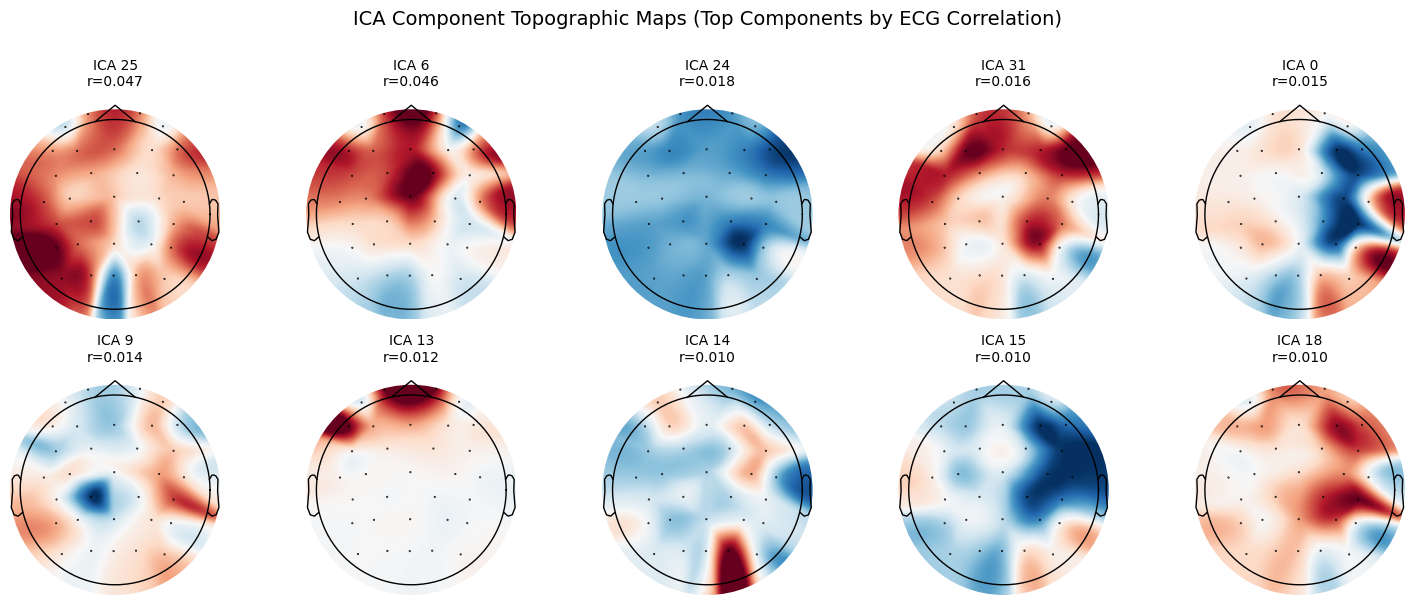

In [36]:
import mne

def plot_ica_topomaps(ica, eeg_channels, correlations, n_components=10):
    """
    Plot topographic maps of ICA components using MNE.
    
    Parameters
    ----------
    ica : FastICA object
        Fitted ICA object with mixing_ matrix
    eeg_channels : list of str
        List of EEG channel names (e.g., ['EEG-ch1', 'EEG-ch2', ...])
    correlations : np.ndarray
        Correlation values with ECG for each component
    n_components : int
        Number of top components to plot (default: 10)
    """
    
    # Create channel names in MNE format (without 'EEG-' prefix for standard montage)
    # Extract channel numbers
    ch_numbers = [int(ch.replace('EEG-ch', '')) for ch in eeg_channels]
    
    # Create MNE-compatible channel names
    # We'll use a standard montage and map to closest channels
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # For 32 channels, use common EEG channel names
    standard_32_channels = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'FC5', 'FC1', 'FC2', 'FC6',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'CP5', 'CP1', 'CP2', 'CP6',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'PO9', 'O1', 'Oz', 'O2', 'PO10',
        'AF7', 'AF8'
    ]
    
    # Use the first N channels from standard layout
    n_channels = len(eeg_channels)
    mne_ch_names = standard_32_channels[:n_channels]
    
    # Create MNE Info object
    info = mne.create_info(
        ch_names=mne_ch_names,
        sfreq=256,
        ch_types='eeg'
    )
    info.set_montage(montage)
    
    # Get ICA mixing matrix (channels x components)
    mixing_matrix = ica.mixing_
    
    # Get top components by correlation
    top_indices = np.argsort(correlations)[-n_components:][::-1]
    
    # Create figure for topomaps
    n_rows = int(np.ceil(n_components / 5))
    fig, axes = plt.subplots(n_rows, 5, figsize=(15, 3 * n_rows))
    axes = axes.flatten()
    
    # Plot each component
    for i, comp_idx in enumerate(top_indices):
        # Get the spatial pattern (mixing matrix column)
        pattern = mixing_matrix[:, comp_idx]
        
        # Plot topomap
        im, _ = mne.viz.plot_topomap(
            pattern,
            info,
            axes=axes[i],
            show=False,
            contours=0,
            cmap='RdBu_r'
        )
        axes[i].set_title(f'ICA {comp_idx}\nr={correlations[comp_idx]:.3f}', 
                         fontsize=10)
    
    # Hide unused subplots
    for i in range(len(top_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('ICA Component Topographic Maps (Top Components by ECG Correlation)', 
                 fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()


# Run after preprocessing
# Uncomment and run this after preprocess_eeg() has been executed:
plot_ica_topomaps(ica, eeg_channels, correlations, n_components=10)

In [ ]:
# Plot ICA component topomaps
if correlations is not None:
    plot_ica_topomaps(ica, eeg_channels, correlations, n_components=10)

## Sanity checks

In [116]:
# Compute duration in minutes for each condition
sampling_rate = 256  # Hz

conditions_to_check = ['RS1', 'MULTI', 'AUD', 'VIZ', 'RS2']
durations = {}

for cond in conditions_to_check:
    start_label = f'{cond}_start'
    stop_label = f'{cond}_stop'
    
    # Find indices where these labels appear
    start_idx = df[df['condition_names'] == start_label].index
    stop_idx = df[df['condition_names'] == stop_label].index
    
    if len(start_idx) > 0 and len(stop_idx) > 0:
        # Get the first occurrence of each
        start_sample = start_idx[0]
        stop_sample = stop_idx[0]
        
        # Calculate duration in samples and convert to minutes
        duration_samples = stop_sample - start_sample
        duration_minutes = duration_samples / sampling_rate / 60
        
        durations[cond] = {
            'start_index': start_sample,
            'stop_index': stop_sample,
            'duration_samples': duration_samples,
            'duration_minutes': duration_minutes
        }
    else:
        durations[cond] = None

# Display results
print(f"Subject {subj} - Condition Durations:\n" + "="*50)
for cond, info in durations.items():
    if info is not None:
        print(f"{cond:6s}: {info['duration_minutes']:6.2f} minutes ({info['duration_samples']:8d} samples)")
        print(f"        Start: {info['start_index']:8d}, Stop: {info['stop_index']:8d}")
    else:
        print(f"{cond:6s}: Not found")
print("="*50)

# Create a summary dataframe
summary_data = []
for cond, info in durations.items():
    if info is not None:
        summary_data.append({
            'Condition': cond,
            'Duration (min)': round(info['duration_minutes'], 2),
            'Duration (samples)': info['duration_samples'],
            'Start Index': info['start_index'],
            'Stop Index': info['stop_index']
        })

summary_df = pd.DataFrame(summary_data)
summary_df

Subject 06 - Condition Durations:
RS1   :   3.37 minutes (   51732 samples)
        Start:    56471, Stop:   108203
MULTI :   4.91 minutes (   75356 samples)
        Start:   387031, Stop:   462387
AUD   :   2.82 minutes (   43302 samples)
        Start:   199403, Stop:   242705
VIZ   :   4.53 minutes (   69513 samples)
        Start:   317437, Stop:   386950
RS2   :   3.39 minutes (   51999 samples)
        Start:   545726, Stop:   597725


Condition  Duration (min)  Duration (samples)  Start Index  Stop Index
0       RS1            3.37               51732        56471      108203
1     MULTI            4.91               75356       387031      462387
2       AUD            2.82               43302       199403      242705
3       VIZ            4.53               69513       317437      386950
4       RS2            3.39               51999       545726      597725

In [59]:
len(df)

580928

In [72]:
eeg_columns = [col for col in df.columns if col.startswith('EEG')]
nan_proportions = df[eeg_columns].isna().mean()
print(nan_proportions)

EEG-ch1     0.393314
EEG-ch2     0.393314
EEG-ch3     0.393314
EEG-ch4     0.393314
EEG-ch5     0.393314
EEG-ch6     0.393314
EEG-ch7     0.393314
EEG-ch8     0.393314
EEG-ch9     0.393314
EEG-ch10    0.393314
EEG-ch11    0.393314
EEG-ch12    0.393314
EEG-ch13    0.393314
EEG-ch14    0.393314
EEG-ch15    0.393314
EEG-ch16    0.393314
EEG-ch17    0.393314
EEG-ch18    0.393314
EEG-ch19    0.393314
EEG-ch20    0.393314
EEG-ch21    0.393314
EEG-ch22    0.393314
EEG-ch23    0.393314
EEG-ch24    0.393314
EEG-ch25    0.393314
EEG-ch26    0.393314
EEG-ch27    0.393314
EEG-ch28    0.393314
EEG-ch29    0.393314
EEG-ch30    0.393314
EEG-ch31    0.393314
EEG-ch32    0.393314
dtype: float64


## Subj 7 debugging

In [169]:
import os
from HNA.modules.utils import (
    load_data,
    align_by_first_triggers,
    find_last_high_indices,
    annotate_conditions,
    get_sync_seconds_for_subject,
    load_audio_for_subject,
)

def annotate_conditions(merged_data, condition_indices, condition_list, sampling_rate=256):
    """
    Adds a 'condition_names' column to merged_data.
    - Merges triggers less than 1 second apart
    - Each of the first N-10 indices in condition_indices is labeled 'AUDIO_SYNC'.
    - The last 10 are mapped to their event label.
    - All other rows are 0.

    Parameters
    ----------
    merged_data : pd.DataFrame
    condition_indices : list of int
        Event indices (can be more than 10; last 10 are mapped to event labels).
    condition_list : list of str
        Three condition names, e.g. ["MULTI", "AUD", "VIZ"].
    sampling_rate : int
        Sampling rate in Hz (default: 256).

    Returns
    -------
    merged_data : pd.DataFrame
        With new column 'condition_names'.
    """
    assert len(condition_list) == 3, "Expected 3 condition names in condition_list."
    
    # Merge triggers less than 1 second apart
    min_spacing_samples = sampling_rate  # 1 second
    merged_indices = []
    
    for i, idx in enumerate(condition_indices):
        if i == 0:
            merged_indices.append(idx)
        else:
            spacing = idx - merged_indices[-1]
            if spacing >= min_spacing_samples:
                merged_indices.append(idx)
            else:
                print(f"  Merging trigger at index {idx} (spacing: {spacing/sampling_rate:.2f}s from previous)")
    
    condition_indices = merged_indices
    print(f"  After merging: {len(condition_indices)} triggers remain")
    
    assert len(condition_indices) >= 10, f"Need at least 10 indices after merging, but only have {len(condition_indices)}."

    # Labels for last 10
    last_labels = [
        'RS1_start', 'RS1_stop',
        f"{condition_list[0]}_start", f"{condition_list[0]}_stop",
        f"{condition_list[1]}_start", f"{condition_list[1]}_stop",
        f"{condition_list[2]}_start", f"{condition_list[2]}_stop",
        'RS2_start', 'RS2_stop'
    ]

    merged_data = merged_data.copy()
    merged_data['condition_names'] = 0

    # AUDIO_SYNC for all indices before the last 10
    for idx in condition_indices[:-10]:
        if 0 <= idx < len(merged_data):
            merged_data.at[idx, 'condition_names'] = 'AUDIO_SYNC'

    # Event label for the last 10
    for idx, label in zip(condition_indices[-10:], last_labels):
        if 0 <= idx < len(merged_data):
            merged_data.at[idx, 'condition_names'] = label

    return merged_data

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)
    


def find_last_high_indices(merged_data, threshold=1950):
    """
    Find the last index in each consecutive run of merged_data['condition_triggers'] > threshold.
    Returns a list of indices.
    """
    high_indices = merged_data.index[merged_data['condition_triggers'] > threshold].tolist()
    high_indices = np.array(high_indices)
    print(f"High indices before filtering: {high_indices}")
    if high_indices.size > 0:
        breaks = np.where(np.diff(high_indices) > 1)[0]
        last_in_run = np.append(breaks, len(high_indices) - 1)
        high_indices = high_indices[last_in_run].tolist()
    return high_indices


SAVEPATH = "../data/processed"
DATA_DIR = "../data"
# DATA_DIR = r'G:\My Drive\COSMIC FUTURE GROUNDED PRESENT\THE SEA PROJECT\PILOT\Sea_Project_data'
JSON_PATH = "../data/audio_sync.json"

conditions = {
    "02": ["MULTI", "AUD", "VIZ"],
    "03": ["MULTI", "VIZ", "AUD"],
    '04': ["AUD", "VIZ", "MULTI"],
    '05': ["VIZ", "AUD", "MULTI"],
    '06': ["AUD", "VIZ", "MULTI"],
    '07': ["AUD", "MULTI", "VIZ"],
    '08': ["MULTI", "AUD", "VIZ"],
}


subj = '07'
# ------- I/O folders (processed) -------
sub_out_dir = os.path.join(SAVEPATH, f"sub-{int(subj):02d}")
audio_out_dir = os.path.join(sub_out_dir, "audio")
tables_out_dir = os.path.join(sub_out_dir, "tables")
ensure_dir(audio_out_dir)
ensure_dir(tables_out_dir)

# ------- Load raw data -------
eeg_data = load_data(subj, "eeg", data_dir=DATA_DIR)
physio_data = load_data(subj, "physio", data_dir=DATA_DIR)
if eeg_data is None or physio_data is None:
    print(f"  Missing EEG/physio data for subj {subj}, skipping.")
# ------- Align EEG/physio on first triggers -------
physio_aligned, eeg_aligned = align_by_first_triggers(physio_data, eeg_data)


# ------- Merge and annotate conditions -------
merged_data = pd.concat([physio_aligned, eeg_aligned], axis=1)
condition_indices = find_last_high_indices(merged_data, threshold=2000)

# Subject-specific corrections
if subj == '05':
    # Remove fifth trigger from the end (index -5)
    print(f"  Before removal: {len(condition_indices)} triggers")
    print(f"  Removing trigger at index {condition_indices[-5]}")
    condition_indices = condition_indices[:-5] + condition_indices[-4:]
    print(f"  After removal: {len(condition_indices)} triggers")

if subj == '04':
    # add trigger 3 minutes after the last trigger
    print(f"  Before addition: {len(condition_indices)} triggers")
    last_trigger = condition_indices[-1]
    additional_trigger = last_trigger + 3 * 60 * 256  # 3 minutes later
    condition_indices.append(additional_trigger)
    print(f"  After addition: {len(condition_indices)} triggers")

print(f"  Found condition trigger indices: {condition_indices}")
cond_list = conditions.get(subj)
if cond_list is None:
    print(f"  No condition ordering for subj {subj}, skipping.")

try:
    merged_annotated = annotate_conditions(merged_data, condition_indices, cond_list)
    u = merged_annotated["condition_names"].unique()
    print("  Unique condition labels:", u)
    audio_sync_count = int((merged_annotated["condition_names"] == "AUDIO_SYNC").sum())
    print("  Number of AUDIO_SYNC events:", audio_sync_count)
except AssertionError as e:
    print(f"  Annotation failed for subj {subj}: {e}. Skipping.")
    
    
# ------- Trim dataframe at last AUDIO_SYNC -------
mask = (merged_annotated["condition_names"] == "AUDIO_SYNC")
if mask.any():
    last_sync_idx = np.flatnonzero(mask.to_numpy())[-1]
    merged_annotated_cut = merged_annotated.iloc[last_sync_idx:].reset_index(drop=True)
    # out_csv_cut = os.path.join(tables_out_dir, "merged_annotated_cut.csv")
    # merged_annotated_cut.to_csv(out_csv_cut, index=False)
    print(f"  Trimmed rows: {len(merged_annotated)} -> {len(merged_annotated_cut)} (cut at index {last_sync_idx})")
    # print(f"  Saved: {out_csv_cut}")
else:
    merged_annotated_cut = merged_annotated
    print("  WARNING: no AUDIO_SYNC found; not trimming dataframe.")

Physio first trigger index: 104, EEG first trigger index: 543
High indices before filtering: [ 75532  75533  75534 ... 579413 579414 579415]
  Found condition trigger indices: [75672, 138251, 169682, 169847, 170025, 178264, 255281, 295848, 364479, 384250, 384355, 384419, 384442, 384460, 385142, 385999, 386001, 386004, 386007, 386016, 386018, 386021, 386026, 386029, 386039, 386081, 386242, 386313, 386751, 387023, 387025, 387719, 387746, 387764, 387768, 387770, 390114, 390125, 390130, 390139, 390173, 390196, 390219, 390233, 390246, 390299, 390305, 390321, 390342, 390356, 390370, 390377, 390383, 390386, 390403, 390409, 390442, 390446, 390450, 390452, 390474, 390476, 390479, 392257, 392259, 392265, 392268, 392274, 392277, 392279, 392284, 392286, 392293, 392298, 392309, 392317, 392321, 392325, 392335, 392337, 392340, 392354, 392356, 392362, 392364, 392366, 392370, 392374, 392379, 392383, 392386, 392390, 392394, 392398, 392401, 392404, 392413, 392416, 392418, 392420, 392427, 392431, 392433, 

Physio first trigger index: 104, EEG first trigger index: 543
High indices before filtering: [ 75532  75533  75534 ... 579413 579414 579415]
  Found condition trigger indices: [75672, 138251, 169682, 169847, 170025, 178264, 255281, 295848, 364479, 384250, 384355, 384419, 384442, 384460, 385142, 385999, 386001, 386004, 386007, 386016, 386018, 386021, 386026, 386029, 386039, 386081, 386242, 386313, 386751, 387023, 387025, 387719, 387746, 387764, 387768, 387770, 390114, 390125, 390130, 390139, 390173, 390196, 390219, 390233, 390246, 390299, 390305, 390321, 390342, 390356, 390370, 390377, 390383, 390386, 390403, 390409, 390442, 390446, 390450, 390452, 390474, 390476, 390479, 392257, 392259, 392265, 392268, 392274, 392277, 392279, 392284, 392286, 392293, 392298, 392309, 392317, 392321, 392325, 392335, 392337, 392340, 392354, 392356, 392362, 392364, 392366, 392370, 392374, 392379, 392383, 392386, 392390, 392394, 392398, 392401, 392404, 392413, 392416, 392418, 392420, 392427, 392431, 392433, 

C:\Users\skite\AppData\Local\Temp\ipykernel_39604\3375567682.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AUDIO_SYNC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_data.at[idx, 'condition_names'] = 'AUDIO_SYNC'


In [12]:
# Convert condition indices to minutes (assuming 256 Hz sampling rate)
sampling_rate = 256

# Create time array in minutes for the entire dataset
time_minutes = np.arange(len(merged_annotated)) / sampling_rate / 60

# Convert condition indices to minutes
condition_indices_minutes = [idx / sampling_rate / 60 for idx in condition_indices]
for idx, minutes in zip(condition_indices, condition_indices_minutes):
    print(f"Index {idx}: {minutes:.2f} minutes from start")

# Plot the full data with vertical lines for triggers
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Get indices where condition names change (non-zero labels)
condition_label_indices = merged_annotated[merged_annotated['condition_names'] != 0].index.tolist()
condition_labels = merged_annotated.loc[condition_label_indices, 'condition_names'].tolist()
condition_label_minutes = [idx / sampling_rate / 60 for idx in condition_label_indices]

# Plot condition_triggers
axes[0].plot(time_minutes, merged_annotated['condition_triggers'], linewidth=0.5)
axes[0].set_ylabel('Condition Triggers')
axes[0].set_title(f'Subject {subj} - Condition Triggers')
for idx_min in condition_indices_minutes:
    axes[0].axvline(x=idx_min, color='r', linestyle='--', alpha=0.7)

# Add condition name labels
for idx_min, label in zip(condition_label_minutes, condition_labels):
    # Place text at the top of each subplot
    for ax_idx, ax in enumerate(axes):
        y_pos = ax.get_ylim()[1] * 0.95  # 95% of the way up the plot
        ax.text(idx_min, y_pos, label, rotation=90, verticalalignment='top', 
                fontsize=8, alpha=0.7, color='blue')

# Plot EEG channel 1
axes[1].plot(time_minutes, merged_annotated['EEG-ch1'], linewidth=0.5)
axes[1].set_ylabel('EEG-ch1')
axes[1].set_title('EEG Channel 1')
for idx_min in condition_indices_minutes:
    axes[1].axvline(x=idx_min, color='r', linestyle='--', alpha=0.7)

# Plot ECG
axes[2].plot(time_minutes, merged_annotated['ecg'], linewidth=0.5)
axes[2].set_ylabel('ECG')
axes[2].set_title('ECG')
axes[2].set_xlabel('Time (minutes)')
for idx_min in condition_indices_minutes:
    axes[2].axvline(x=idx_min, color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


NameError: name 'merged_annotated' is not defined

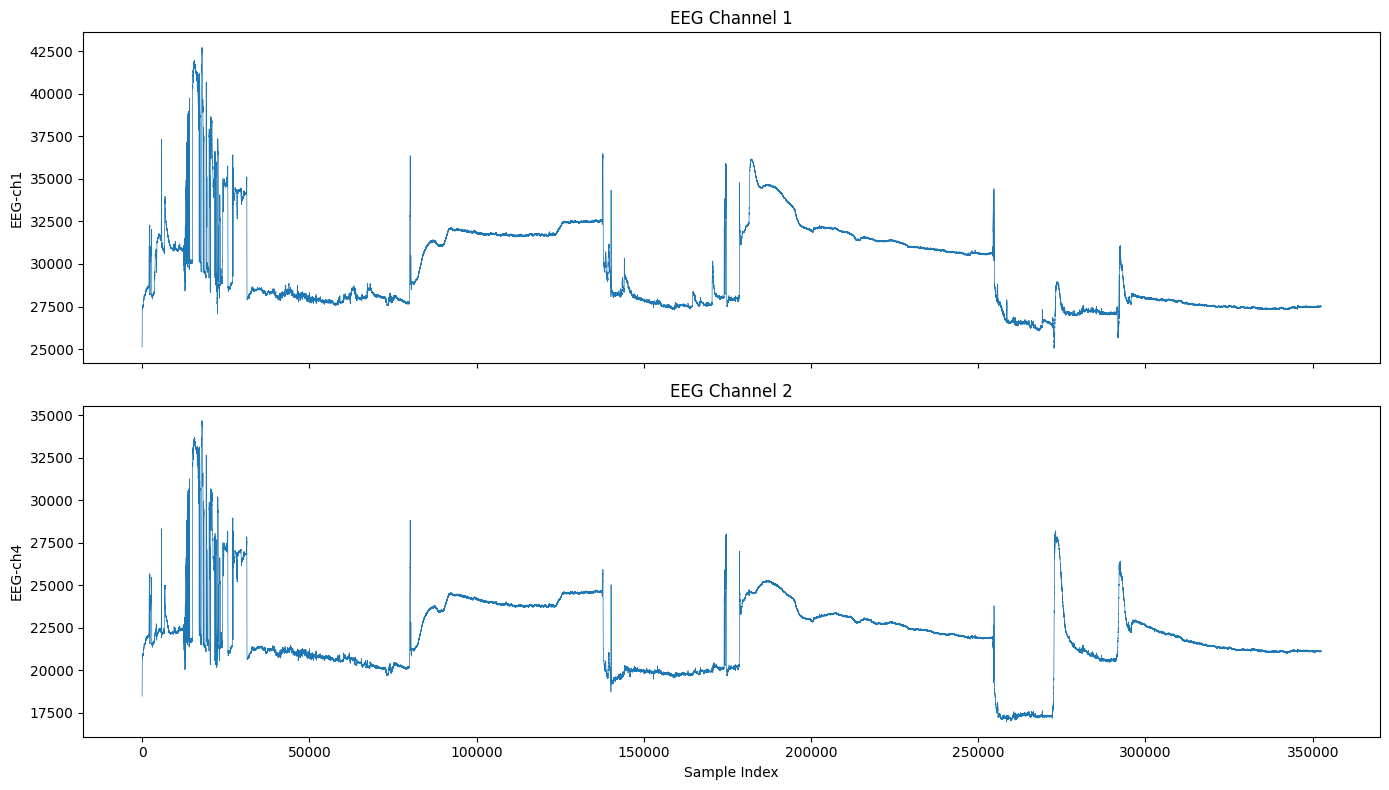

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(merged_annotated['EEG-ch1'], linewidth=0.5)
axes[0].set_ylabel('EEG-ch1')
axes[0].set_title('EEG Channel 1')

axes[1].plot(merged_annotated['EEG-ch2'], linewidth=0.5)
axes[1].set_ylabel('EEG-ch4')
axes[1].set_title('EEG Channel 2')
axes[1].set_xlabel('Sample Index')

plt.tight_layout()
plt.show()

## Subj 8 debugging

In [45]:
import os
from HNA.modules.utils import (
    load_data,
    align_by_first_triggers,
    find_last_high_indices,
    annotate_conditions,
    get_sync_seconds_for_subject,
    load_audio_for_subject,
)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)
    


def find_last_high_indices(merged_data, threshold=1950):
    """
    Find the last index in each consecutive run of merged_data['condition_triggers'] > threshold.
    Returns a list of indices.
    """
    high_indices = merged_data.index[merged_data['condition_triggers'] > threshold].tolist()
    high_indices = np.array(high_indices)
    print(f"High indices before filtering: {high_indices}")
    if high_indices.size > 0:
        breaks = np.where(np.diff(high_indices) > 1)[0]
        last_in_run = np.append(breaks, len(high_indices) - 1)
        high_indices = high_indices[last_in_run].tolist()
    return high_indices


SAVEPATH = "../data/processed"
DATA_DIR = "../data"
# DATA_DIR = r'G:\My Drive\COSMIC FUTURE GROUNDED PRESENT\THE SEA PROJECT\PILOT\Sea_Project_data'
JSON_PATH = "../data/audio_sync.json"

conditions = {
    "02": ["MULTI", "AUD", "VIZ"],
    "03": ["MULTI", "VIZ", "AUD"],
    # '04': ["AUD", "VIZ", "MULTI"],
    '05': ["VIZ", "AUD", "MULTI"],
    '06': ["AUD", "VIZ", "MULTI"],
    '07': ["AUD", "MULTI", "VIZ"],
    '08': ["MULTI", "AUD", "VIZ"],
}


subj = '08'
# ------- I/O folders (processed) -------
sub_out_dir = os.path.join(SAVEPATH, f"sub-{int(subj):02d}")
audio_out_dir = os.path.join(sub_out_dir, "audio")
tables_out_dir = os.path.join(sub_out_dir, "tables")
ensure_dir(audio_out_dir)
ensure_dir(tables_out_dir)

# ------- Load raw data -------
eeg_data = load_data(subj, "eeg", data_dir=DATA_DIR)
physio_data = load_data(subj, "physio", data_dir=DATA_DIR)
if eeg_data is None or physio_data is None:
    print(f"  Missing EEG/physio data for subj {subj}, skipping.")
# ------- Align EEG/physio on first triggers -------
physio_aligned, eeg_aligned = align_by_first_triggers(physio_data, eeg_data)

# ------- Merge and annotate conditions -------
merged_data = pd.concat([physio_aligned, eeg_aligned], axis=1)
condition_indices = find_last_high_indices(merged_data, threshold=1950)


print(f"  Found condition trigger indices: {condition_indices}")
cond_list = conditions.get(subj)
if cond_list is None:
    print(f"  No condition ordering for subj {subj}, skipping.")

try:
    merged_annotated = annotate_conditions(merged_data, condition_indices, cond_list)
    u = merged_annotated["condition_names"].unique()
    print("  Unique condition labels:", u)
    audio_sync_count = int((merged_annotated["condition_names"] == "AUDIO_SYNC").sum())
    print("  Number of AUDIO_SYNC events:", audio_sync_count)
except AssertionError as e:
    print(f"  Annotation failed for subj {subj}: {e}. Skipping.")

Physio first trigger index: 1, EEG first trigger index: 658
High indices before filtering: [0 1 2 3 4 5 6]
  Found condition trigger indices: [6]
  Annotation failed for subj 08: Need at least 10 indices.. Skipping.


In [51]:
physio_data

ecg   respiration  physio_triggers  condition_triggers
0   9714.324932  52843.579674              0.0         1978.863466
1   9709.586905  52886.733627              1.0         1978.442308
2   9703.743337  52874.850655              0.0         1978.284373
3   9711.955918  52895.176792              0.0         1979.916361
4   9707.586404  52871.410847              0.0         1978.179084
5   9703.901272  52871.723557              0.0         1979.547847
6   9711.008313  52867.971039              0.0         1982.285374
7   9707.639049  52889.860725              0.0         1980.548098
8           NaN  52872.036266              0.0                 NaN
9           NaN  52873.287106              NaN                 NaN
10          NaN  52896.114922              NaN                 NaN
11          NaN  52878.290462              NaN                 NaN
12          NaN  52870.472717              NaN                 NaN
13          NaN  52873.287106              NaN                 NaN
14          NaN  52872.661686              NaN                 NaN